<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/Microlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/projects/project-notebooks/Microlearning.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Microlearning

***Microlearning: Credit assignment and local learning rules in artificial and neural systems***

**By Neuromatch Academy**

__Content creators:__ Colleen J. Gillon & Klara Kaleb

__Content reviewers:__ Colleen J. Gillon, Klara Kaleb, Eva Dyer

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk

---

## Background
To learn effectively, our brain must coordinate synaptic updates across its network of neurons. The question of how the brain does this is called the credit assignment problem. Deep neural networks are a leading model of learning in the brain, and are typically trained using gradient descent via backpropagation. However, backpropagation is widely agreed to be biologically implausible. Therefore, to understand how the brain solves the credit assignment problem, we must find learning rules that are both biologically plausible and effective for learning. In this project, we will explore more biologically plausible learning rules proposed as alternatives to backpropagation, compare them to error backpropagation, and test whether we can infer what type of learning rule the brain might be using.

## Project Setup
This project builds on a basic feedforward network trained to classify MNIST images (Q1). We then implement biologically plausible rules, compute performance and learning-related metrics (Q2-Q4 & Q7), to then evaluate (1) how consistent and learning-rule specific the metrics are (Q5, Q8-9), or (2) how these rules fare in more complex learning scenarios (Q6, Q10).

**Relevant references:**  
- Course materials from Neuromatch's NeuroAI day on Microlearning
- Review discussing backpropagation in the brain: [Lillicrap et al., 2020, Nature Reviews Neuroscience](https://www.nature.com/articles/s41583-020-0277-3)
- Study on the reliability of different metrics for inferring learning rules: [Nayebi et al., 2020, NeurIPS](https://proceedings.neurips.cc/paper_files/paper/2020/file/1ba922ac006a8e5f2b123684c2f4d65f-Paper.pdf)

In [ ]:
# @title Project Background

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'y7qlVo-KzU8')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Project slides

from IPython.display import IFrame
print("If you want to download the slides: https://osf.io/download/fjaqp/")
IFrame(src="https://mfr.ca-1.osf.io/render?url=https://osf.io/download/fjaqp/?direct%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/fjaqp/


In [ ]:
#@title Project Template
from IPython.display import Image, display
import os
from pathlib import Path

url = "https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/MicrolearningProjectTemplate.svg?raw=true"

display(Image(url=url))

## Section 1: Initial setup

In [ ]:
# @title Importing dependencies

from IPython.display import Image, SVG, display
import os
from pathlib import Path

import random
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torchvision
import contextlib
import io

In [ ]:
# @title Figure settings

import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

### 1.1 Download MNIST dataset

The first step is to download the [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digits dataset [1], which you will be using in this project. It is provided as a training dataset (60,000 examples) and a test dataset (10,000 examples). We can split the training dataset to obtain a training (e.g., 80%) and a validation set (e.g., 20%). In addition, since the dataset is quite large, we also suggest keeping only half of each subset, as this will make training the models faster.


[1] Deng, L. (2012). The MNIST database of handwritten digit images for machine learning research. _IEEE Signal Processing Magazine_, 29(6), 141–142, https://ieeexplore.ieee.org/document/6296535.

**Note:** The download process may try a few sources before succeeding. `HTTP Error 403: Forbidden` or `HTTP Error 503: Service Unavailable` errors can be ignored.

In [ ]:
# @markdown `download_mnist()`: Function to download MNIST.

def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output

      full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform
          )
      full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform
          )

  train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set,
      [train_prop * keep_prop, valid_prop * keep_prop, discard_prop]
      )
  test_set, _ = torch.utils.data.random_split(
      full_test_set,
      [keep_prop, discard_prop]
      )

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set

In [ ]:
train_set, valid_set, test_set = download_mnist()

  0%|          | 0/9912422 [00:00<?, ?it/s]

  6%|▋         | 622592/9912422 [00:00<00:01, 5087743.11it/s]

 83%|████████▎ | 8192000/9912422 [00:00<00:00, 43046711.98it/s]

100%|██████████| 9912422/9912422 [00:00<00:00, 43017218.23it/s]

  0%|          | 0/28881 [00:00<?, ?it/s]

100%|██████████| 28881/28881 [00:00<00:00, 1162251.80it/s]

  0%|          | 0/1648877 [00:00<?, ?it/s]

 40%|███▉      | 655360/1648877 [00:00<00:00, 5443622.72it/s]

100%|██████████| 1648877/1648877 [00:00<00:00, 11239960.34it/s]

  0%|          | 0/4542 [00:00<?, ?it/s]

100%|██████████| 4542/4542 [00:00<00:00, 7813998.67it/s]

Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


#### 1.2 Explore the dataset

In [ ]:
#@markdown To get started exploring the dataset, here are a few plotting functions:

#@markdown `get_plotting_color()`: Returns a color for the specific dataset, e.g. "train" or model index.
def get_plotting_color(dataset="train", model_idx=None):
  if model_idx is not None:
    dataset = None

  if model_idx == 0 or dataset == "train":
    color = "#1F77B4" # blue
  elif model_idx == 1 or dataset == "valid":
    color = "#FF7F0E" # orange
  elif model_idx == 2 or dataset == "test":
    color = "#2CA02C" # green
  else:
    if model_idx is not None:
      raise NotImplementedError("Colors only implemented for up to 3 models.")
    else:
      raise NotImplementedError(
          f"{dataset} dataset not recognized. Expected 'train', 'valid' "
          "or 'test'."
          )

  return color


#@markdown `plot_examples(subset)`: Plot examples from the dataset organized by their predicted class
#@markdown (if a model is provided) or by their class label otherwise
def plot_examples(subset, num_examples_per_class=8, MLP=None, seed=None,
                  batch_size=32, num_classes=10, ax=None):
  """
  Function for visualizing example images from the dataset, organized by their
  predicted class, if a model is provided, or by their class, otherwise.

  Arguments:
  - subset (torch dataset or torch dataset subset): dataset from which to
    visualized images.
  - num_examples_per_class (int, optional): number of examples to visualize per
    class
  - MLP (MultiLayerPerceptron or None, optional): model to use to retrieve the
    predicted class for each image. If MLP is None, images will be organized by
    their class label. Otherwise, images will be organized by their predicted
    class.
  - seed (int or None, optional): Seed to use to randomly sample images to
    visualize.
  - batch_size (int, optional): If MLP is not None, number of images to
    retrieve predicted class for at one time.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if MLP is None:
    xlabel = "Class"
  else:
    MLP.eval()
    xlabel = "Predicted class"

  if ax is None:
    fig_wid = min(8, num_classes * 0.6)
    fig_hei = min(8, num_examples_per_class * 0.6)
    _, ax = plt.subplots(figsize=(fig_wid, fig_hei))

  if seed is None:
    generator = None
  else:
    generator = torch.Generator()
    generator.manual_seed(seed)

  loader = torch.utils.data.DataLoader(
      subset, batch_size=batch_size, shuffle=True, generator=generator
      )

  plot_images = {i: list() for i in range(num_classes)}
  with torch.no_grad():
    for X, y in loader:
      if MLP is not None:
        y = MLP(X)
        y = torch.argmax(y, axis=1)

      done = True
      for i in range(num_classes):
        num_to_add = int(num_examples_per_class - len(plot_images[i]))
        if num_to_add:
          add_images = np.where(y == i)[0]
          if len(add_images):
            for add_i in add_images[: num_to_add]:
              plot_images[i].append(X[add_i, 0].numpy())
          if len(plot_images[i]) != num_examples_per_class:
            done = False

      if done:
        break

  hei, wid = X[0, 0].shape
  final_image = np.full((num_examples_per_class * hei, num_classes * wid), np.nan)
  for i, images in plot_images.items():
    if len(images):
      final_image[: len(images) * hei, i * wid: (i + 1) * wid] = np.vstack(images)

  ax.imshow(final_image, cmap="gray")

  ax.set_xlabel(xlabel)
  ax.set_xticks((np.arange(num_classes) + 0.5) * wid)
  ax.set_xticklabels([f"{int(i)}" for i in range(num_classes)])
  ax.set_yticks([])
  ax.set_title(f"Examples per {xlabel.lower()}")

  return ax

#@markdown `plot_class_distribution(train_set)`: Plots the distribution of classes in each set (train, validation, test).
def plot_class_distribution(train_set, valid_set=None, test_set=None,
                            num_classes=10, ax=None):
  """
  Function for plotting the number of examples per class in each subset.

  Arguments:
  - train_set (torch dataset or torch dataset subset): training dataset
  - valid_set (torch dataset or torch dataset subset, optional): validation
    dataset
  - test_set (torch dataset or torch dataset subset, optional): test
    dataset
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  bins = np.arange(num_classes + 1) - 0.5

  for dataset_name, dataset in [
      ("train", train_set), ("valid", valid_set), ("test", test_set)
      ]:
    if dataset is None:
      continue

    if hasattr(dataset, "dataset"):
      targets = dataset.dataset.targets[dataset.indices]
    else:
      targets = dataset.targets

    outputs = ax.hist(
        targets,
        bins=bins,
        alpha=0.3,
        color=get_plotting_color(dataset_name),
        label=dataset_name,
        )

    per_class = len(targets) / num_classes
    ax.axhline(
        per_class,
        ls="dashed",
        color=get_plotting_color(dataset_name),
        alpha=0.8
        )

  ax.set_xticks(range(num_classes))
  ax.set_title("Counts per class")
  ax.set_xlabel("Class")
  ax.set_ylabel("Count")
  ax.legend(loc="center right")

  return ax

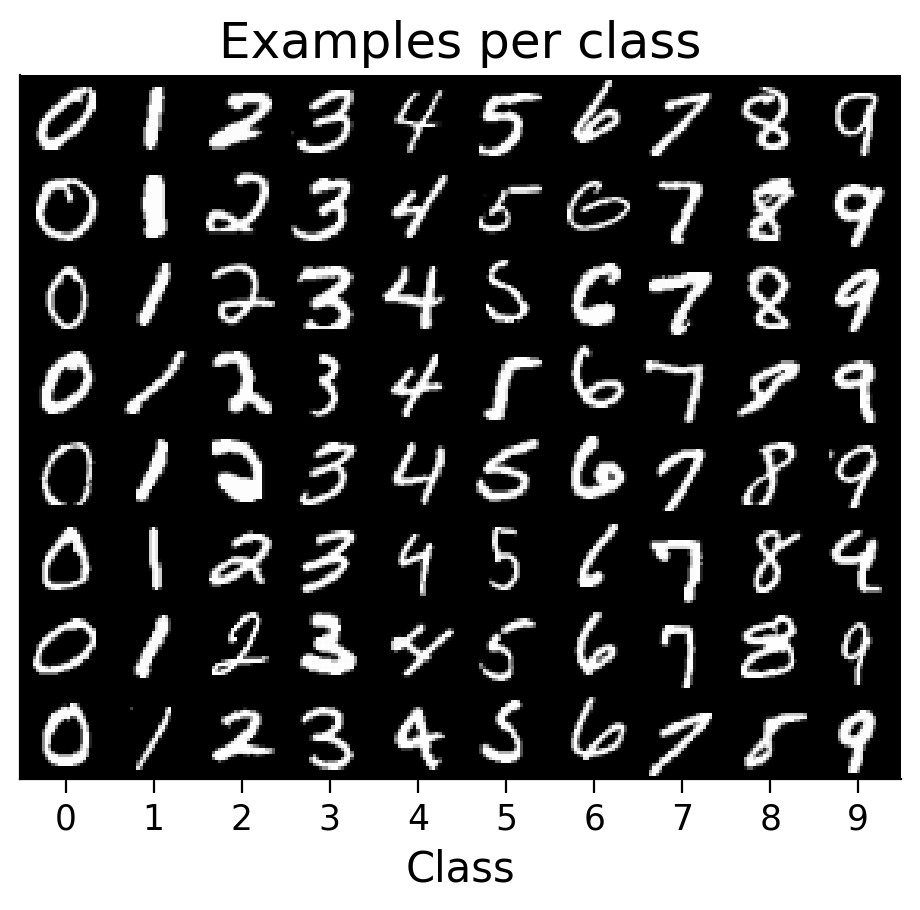

In [ ]:
plot_examples(train_set);

## Section 2: Training a basic model

### 2.1 Defining a basic model

Next, we can define a basic model to train on this MNIST classification task.

First, it is helpful to define a **few hyperparameters** (`NUM_INPUTS` and `NUM_OUTPUTS`) to store the input size and output size the model needs to have for this task.

The `MultiLayerPerceptron` class, provided here, initializes a **multilayer perceptron (MLP) with one hidden layer**. Feel free to expand or change the class, if you would like to use a different or more complex model, or add functionalities.

This class has several **basic methods**:
- `__init__(self)`: To initialize the model.
- `_set_activation(self)`: To set the specified activation function for the hidden layer. (The output layer has a softmax activation.)
- `forward(self, X)`: To define how activity is passed through the model.

It also has additional methods that will be **helpful later on** for collecting metrics from the models:
- `_store_initial_weights_biases(self)`: To store the initial weights and biases.
- `forward_backprop(self, X)`: For when we will be comparing the gradients computed by alternative learning rules to the gradients computed by error backpropagation.
- `list_parameters(self)`: For convenience in retrieving a list of the model's parameters.
- `gather_gradient_dict(self)`: For gathering the gradients of the model's parameters.

In [ ]:
NUM_INPUTS = np.product(train_set.dataset.data[0].shape) # size of an MNIST image
NUM_OUTPUTS = 10 # number of MNIST classes

class MultiLayerPerceptron(torch.nn.Module):
  """
  Simple multilayer perceptron model class with one hidden layer.
  """

  def __init__(
      self,
      num_inputs=NUM_INPUTS,
      num_hidden=100,
      num_outputs=NUM_OUTPUTS,
      activation_type="sigmoid",
      bias=False,
      ):
    """
    Initializes a multilayer perceptron with a single hidden layer.

    Arguments:
    - num_inputs (int, optional): number of input units (i.e., image size)
    - num_hidden (int, optional): number of hidden units in the hidden layer
    - num_outputs (int, optional): number of output units (i.e., number of
      classes)
    - activation_type (str, optional): type of activation to use for the hidden
      layer ('sigmoid', 'tanh', 'relu' or 'linear')
    - bias (bool, optional): if True, each linear layer will have biases in
      addition to weights
    """


    super().__init__()

    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs
    self.activation_type = activation_type
    self.bias = bias

    # default weights (and biases, if applicable) initialization is used
    # see https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/linear.py
    self.lin1 = torch.nn.Linear(num_inputs, num_hidden, bias=bias)
    self.lin2 = torch.nn.Linear(num_hidden, num_outputs, bias=bias)

    self._store_initial_weights_biases()

    self._set_activation() # activation on the hidden layer
    self.softmax = torch.nn.Softmax(dim=1) # activation on the output layer


  def _store_initial_weights_biases(self):
    """
    Stores a copy of the network's initial weights and biases.
    """

    self.init_lin1_weight = self.lin1.weight.data.clone()
    self.init_lin2_weight = self.lin2.weight.data.clone()
    if self.bias:
      self.init_lin1_bias = self.lin1.bias.data.clone()
      self.init_lin2_bias = self.lin2.bias.data.clone()

  def _set_activation(self):
    """
    Sets the activation function used for the hidden layer.
    """

    if self.activation_type.lower() == "sigmoid":
      self.activation = torch.nn.Sigmoid() # maps to [0, 1]
    elif self.activation_type.lower() == "tanh":
      self.activation = torch.nn.Tanh() # maps to [-1, 1]
    elif self.activation_type.lower() == "relu":
      self.activation = torch.nn.ReLU() # maps to positive
    elif self.activation_type.lower() == "identity":
      self.activation = torch.nn.Identity() # maps to same
    else:
      raise NotImplementedError(
          f"{self.activation_type} activation type not recognized. Only "
          "'sigmoid', 'relu' and 'identity' have been implemented so far."
          )

  def forward(self, X, y=None):
    """
    Runs a forward pass through the network.

    Arguments:
    - X (torch.Tensor): Batch of input images.
    - y (torch.Tensor, optional): Batch of targets. This variable is not used
      here. However, it may be needed for other learning rules, to it is
      included as an argument here for compatibility.

    Returns:
    - y_pred (torch.Tensor): Predicted targets.
    """

    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
    y_pred = self.softmax(self.lin2(h))
    return y_pred

  def forward_backprop(self, X):
    """
    Identical to forward(). Should not be overwritten when creating new
    child classes to implement other learning rules, as this method is used
    to compare the gradients calculated with other learning rules to those
    calculated with backprop.
    """

    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
    y_pred = self.softmax(self.lin2(h))
    return y_pred


  def list_parameters(self):
    """
    Returns a list of model names for a gradient dictionary.

    Returns:
    - params_list (list): List of parameter names.
    """

    params_list = list()

    for layer_str in ["lin1", "lin2"]:
      params_list.append(f"{layer_str}_weight")
      if self.bias:
        params_list.append(f"{layer_str}_bias")

    return params_list


  def gather_gradient_dict(self):
    """
    Gathers a gradient dictionary for the model's parameters. Raises a
    runtime error if any parameters have no gradients.

    Returns:
    - gradient_dict (dict): A dictionary of gradients for each parameter.
    """

    params_list = self.list_parameters()

    gradient_dict = dict()
    for param_name in params_list:
      layer_str, param_str = param_name.split("_")
      layer = getattr(self, layer_str)
      grad = getattr(layer, param_str).grad
      if grad is None:
        raise RuntimeError("No gradient was computed")
      gradient_dict[param_name] = grad.detach().clone().numpy()

    return gradient_dict

### 2.2 Initializing the model

We can now **initialize an MLP**. Feel free to change the number of hidden units, change the activation function or include biases in the model.  

Currently, the `"sigmoid"`, `"TanH"`, `"ReLU"` and `"identity"` activation functions are implemented, but you can add more by editing the `_set_activation(self)` method of the `MultiLayerPerceptron` class defined above.

We have set `BIAS=False` for simplicity.

We will also initialize the dataloaders. Feel free to select a different batch size (`BATCH_SIZE`) when training your models.

In [ ]:
# Model
NUM_HIDDEN = 100
ACTIVATION = "sigmoid" # output constrained between 0 and 1
BIAS = False

MLP = MultiLayerPerceptron(
    num_hidden=NUM_HIDDEN,
    activation_type=ACTIVATION,
    bias=BIAS,
    )


# Dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

### 2.3 Defining and initializing an optimizer

Here, we define a **basic optimizer** that updates the weights and biases of the model based on the gradients saved. This optimizer is equivalent to a simple [Stochastic Gradient Descent optimizer](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD) (`torch.optim.SGD()`) applied to mini-batch data.

It has two methods:
- `__init__(self)`: To initialize the optimizer. Any arguments passed after `params` should be added to the `defaults` dictionary, which is passed to the parents class. These arguments are then added to each parameter group's dictionary, allowing them to be accessed in `step(self)`.
- `step(self)`: Makes an update to the model parameters.

This optimizer can be extended later, if needed, when implementing more complex learning rules.

In [ ]:
class BasicOptimizer(torch.optim.Optimizer):
  """
  Simple optimizer class based on the SGD optimizer.
  """
  def __init__(self, params, lr=0.01, weight_decay=0):
    """
    Initializes a basic optimizer object.

    Arguments:
    - params (generator): Generator for torch model parameters.
    - lr (float, optional): Learning rate.
    - weight_decay (float, optional): Weight decay.
    """

    if lr < 0.0:
        raise ValueError(f"Invalid learning rate: {lr}")
    if weight_decay < 0.0:
        raise ValueError(f"Invalid weight_decay value: {weight_decay}")

    defaults = dict(
        lr=lr,
        weight_decay=weight_decay,
        )

    super().__init__(params, defaults)

  def step(self):
      """
      Performs a single optimization step.
      """

      for group in self.param_groups:
        for p in group["params"]:

          # only update parameters with gradients
          if p.grad is not None:

            # apply weight decay to gradient, if applicable
            if group["weight_decay"] != 0:
              p.grad = p.grad.add(p, alpha=group["weight_decay"])

            # apply gradient-based update
            p.data.add_(p.grad, alpha=-group["lr"])

We can now **initialize an optimizer**. Feel free to change to learning rate (`LR`) that the optimizer is initialized with, or to add a weight decay.

In [ ]:
LR = 0.01
backprop_optimizer = BasicOptimizer(MLP.parameters(), lr=LR)

### 2.4 Training a basic model

In [ ]:
#@markdown `train_model(MLP, train_loader, valid_loader, optimizer)`: Main function.
#@markdown Trains the model across epochs. Aggregates loss and accuracy statistics
#@markdown from the training and validation datasets into a results dictionary which is returned.
def train_model(MLP, train_loader, valid_loader, optimizer, num_epochs=5):
  """
  Train a model for several epochs.

  Arguments:
  - MLP (torch model): Model to train.
  - train_loader (torch dataloader): Dataloader to use to train the model.
  - valid_loader (torch dataloader): Dataloader to use to validate the model.
  - optimizer (torch optimizer): Optimizer to use to update the model.
  - num_epochs (int, optional): Number of epochs to train model.

  Returns:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  """

  results_dict = {
      "avg_train_losses": list(),
      "avg_valid_losses": list(),
      "avg_train_accuracies": list(),
      "avg_valid_accuracies": list(),
  }

  for e in tqdm(range(num_epochs)):
    no_train = True if e == 0 else False # to get a baseline
    latest_epoch_results_dict = train_epoch(
        MLP, train_loader, valid_loader, optimizer=optimizer, no_train=no_train
        )

    for key, result in latest_epoch_results_dict.items():
      if key in results_dict.keys() and isinstance(results_dict[key], list):
        results_dict[key].append(latest_epoch_results_dict[key])
      else:
        results_dict[key] = result # copy latest

  return results_dict


def train_epoch(MLP, train_loader, valid_loader, optimizer, no_train=False):
  """
  Train a model for one epoch.

  Arguments:
  - MLP (torch model): Model to train.
  - train_loader (torch dataloader): Dataloader to use to train the model.
  - valid_loader (torch dataloader): Dataloader to use to validate the model.
  - optimizer (torch optimizer): Optimizer to use to update the model.
  - no_train (bool, optional): If True, the model is not trained for the
    current epoch. Allows a baseline (chance) performance to be computed in the
    first epoch before training starts.

  Returns:
  - epoch_results_dict (dict): Dictionary storing epoch results on training
    and validation data.
  """

  criterion = torch.nn.NLLLoss()

  epoch_results_dict = dict()
  for dataset in ["train", "valid"]:
    for sub_str in ["correct_by_class", "seen_by_class"]:
      epoch_results_dict[f"{dataset}_{sub_str}"] = {
          i:0 for i in range(MLP.num_outputs)
          }

  MLP.train()
  train_losses, train_acc = list(), list()
  for X, y in train_loader:
    y_pred = MLP(X, y=y)
    loss = criterion(torch.log(y_pred), y)
    acc = (torch.argmax(y_pred.detach(), axis=1) == y).sum() / len(y)
    train_losses.append(loss.item() * len(y))
    train_acc.append(acc.item() * len(y))
    update_results_by_class_in_place(
        y, y_pred.detach(), epoch_results_dict, dataset="train",
        num_classes=MLP.num_outputs
        )
    optimizer.zero_grad()
    if not no_train:
      loss.backward()
      optimizer.step()

  num_items = len(train_loader.dataset)
  epoch_results_dict["avg_train_losses"] = np.sum(train_losses) / num_items
  epoch_results_dict["avg_train_accuracies"] = np.sum(train_acc) / num_items * 100

  MLP.eval()
  valid_losses, valid_acc = list(), list()
  with torch.no_grad():
    for X, y in valid_loader:
      y_pred = MLP(X)
      loss = criterion(torch.log(y_pred), y)
      acc = (torch.argmax(y_pred, axis=1) == y).sum() / len(y)
      valid_losses.append(loss.item() * len(y))
      valid_acc.append(acc.item() * len(y))
      update_results_by_class_in_place(
          y, y_pred.detach(), epoch_results_dict, dataset="valid"
          )

  num_items = len(valid_loader.dataset)
  epoch_results_dict["avg_valid_losses"] = np.sum(valid_losses) / num_items
  epoch_results_dict["avg_valid_accuracies"] = np.sum(valid_acc) / num_items * 100

  return epoch_results_dict


def update_results_by_class_in_place(y, y_pred, result_dict, dataset="train",
                                     num_classes=10):
  """
  Updates results dictionary in place during a training epoch by adding data
  needed to compute the accuracies for each class.

  Arguments:
  - y (torch Tensor): target labels
  - y_pred (torch Tensor): predicted targets
  - result_dict (dict): Dictionary storing epoch results on training
    and validation data.
  - dataset (str, optional): Dataset for which results are being added.
  - num_classes (int, optional): Number of classes.
  """

  correct_by_class = None
  seen_by_class = None

  y_pred = np.argmax(y_pred, axis=1)
  if len(y) != len(y_pred):
    raise RuntimeError("Number of predictions does not match number of targets.")

  for i in result_dict[f"{dataset}_seen_by_class"].keys():
    idxs = np.where(y == int(i))[0]
    result_dict[f"{dataset}_seen_by_class"][int(i)] += len(idxs)

    num_correct = int(sum(y[idxs] == y_pred[idxs]))
    result_dict[f"{dataset}_correct_by_class"][int(i)] += num_correct

Once the model and optimizer have been initialized, we can now **train our model** using backpropagation for a few epochs, and collect the classification results dictionary.

In [ ]:
NUM_EPOCHS = 5

MLP_results_dict = train_model(
    MLP,
    train_loader,
    valid_loader,
    optimizer=backprop_optimizer,
    num_epochs=NUM_EPOCHS
    )

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:05<00:20,  5.15s/it]

 40%|████      | 2/5 [00:10<00:15,  5.25s/it]

 60%|██████    | 3/5 [00:15<00:10,  5.28s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.30s/it]

100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

**Note:** The training function does not use the `test_loader`. This additional dataloader can be used to evaluate the models if, for example, you need use the validation set for model selection.

## Section 3. Inspecting a model's performance

The **results dictionary** (`MLP_results_dict`) returned by `train_model()` contains the following keys:
- `avg_train_losses`: Average training loss per epoch.
- `avg_valid_losses`: Average validation loss per epoch.
- `avg_train_accuracies`: Average training accuracies per epoch.
- `avg_valid_losses`: Average validation accuracies per epoch.
- `train_correct_by_class`: Number of correctly classified training images for each class (last epoch only).
- `train_seen_by_class`: Number of training images for each class (last epoch only).
- `valid_correct_by_class`: Number of correctly classified validation images for each class (last epoch only).
- `valid_seen_by_class`: Number of validation images for each class (last epoch only).

Next, we can inspect our model's performance by visualizing various **metrics**, e.g., classification loss, accuracy, accuracy by class, weights. A few example functions are provided for plotted various metrics collected across learning.

In [ ]:
#@markdown `plot_results(results_dict)`: Plots classification losses and
#@markdown accuracies across epochs for the training and validation sets.
def plot_results(results_dict, num_classes=10, ax=None):
  """
  Function for plotting losses and accuracies across learning.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (float, optional): Number of classes, used to calculate chance
    accuracy.
  - ax (plt subplot, optional): Axis on which to plot results. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which results were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(7, 3.5))

  loss_ax = ax
  acc_ax = None

  chance = 100 / num_classes

  plotted = False
  for result_type in ["losses", "accuracies"]:
    for dataset in ["train", "valid"]:
      key = f"avg_{dataset}_{result_type}"
      if key in results_dict.keys():
        if result_type == "losses":
          ylabel = "Loss"
          plot_ax = loss_ax
          ls = None
        elif result_type == "accuracies":
          if acc_ax is None:
            acc_ax = ax.twinx()
            acc_ax.spines[["right"]].set_visible(True)
            acc_ax.axhline(chance, ls="dashed", color="k", alpha=0.8)
            acc_ax.set_ylim(-5, 105)
          ylabel = "Accuracy (%)"
          plot_ax = acc_ax
          ls = "dashed"
        else:
          raise RuntimeError(f"{result_type} result type not recognized.")

        data = results_dict[key]
        plot_ax.plot(
            data,
            ls=ls,
            label=dataset,
            alpha=0.8,
            color=get_plotting_color(dataset)
            )
        plot_ax.set_ylabel(ylabel)
        plotted = True

  if plotted:
    ax.legend(loc="center left")
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels([f"{int(e)}" for e in range(len(data))])
    ymin, ymax = ax.get_ylim()
    if ymin > 0:
      ymin = 0
      pad = (ymax - ymin) * 0.05
      ax.set_ylim(ymin - pad, ymax + pad)

  else:
    raise RuntimeError("No data found to plot.")

  ax.set_title("Performance across learning")
  ax.set_xlabel("Epoch")

  return ax


#@markdown `plot_scores_per_class(results_dict)`: Plots the classification
#@markdown accuracies by class for the training and validation sets (for the last epoch).
def plot_scores_per_class(results_dict, num_classes=10, ax=None):
  """
  Function for plotting accuracy scores for each class.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot accuracies. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which accuracies were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  avgs = list()
  ax.set_prop_cycle(None) # reset color cycle
  for s, dataset in enumerate(["train", "valid"]):
    correct_by_class = results_dict[f"{dataset}_correct_by_class"]
    seen_by_class = results_dict[f"{dataset}_seen_by_class"]
    xs, ys = list(), list()
    for i, total in seen_by_class.items():
      xs.append(i + 0.3 * (s - 0.5))
      if total == 0:
        ys.append(np.nan)
      else:
        ys.append(100 * correct_by_class[i] / total)

    avg_key = f"avg_{dataset}_accuracies"
    if avg_key in results_dict.keys():
      ax.axhline(
          results_dict[avg_key][-1], ls="dashed", alpha=0.8,
          color=get_plotting_color(dataset)
          )

    ax.bar(
        xs, ys, label=dataset, width=0.3, alpha=0.8,
        color=get_plotting_color(dataset)
        )

  ax.set_xticks(range(num_classes))
  ax.set_xlabel("Class")
  ax.set_ylabel("Accuracy (%)")
  ax.set_title("Class scores")
  ax.set_ylim(-5, 105)

  chance = 100 / num_classes
  ax.axhline(chance, ls="dashed", color="k", alpha=0.8)

  ax.legend()

  return ax


#@markdown `plot_weights(MLP)`: Plots weights before and after training.
def plot_weights(MLP, shared_colorbar=False):
  """
  Function for plotting model weights and biases before and after learning.

  Arguments:
  - MLP (torch model): Model for which to plot weights and biases.
  - shared_colorbar (bool, optional): If True, one colorbar is shared for all
      parameters.

  Returns:
  - ax (plt subplot array): Axes on which weights and biases were plotted.
  """

  param_names = MLP.list_parameters()

  params_images = dict()
  pre_means = dict()
  post_means = dict()
  vmin, vmax = np.inf, -np.inf
  for param_name in param_names:
    layer, param_type = param_name.split("_")
    init_params = getattr(MLP, f"init_{layer}_{param_type}").numpy()
    separator = np.full((1, init_params.shape[-1]), np.nan)
    last_params = getattr(getattr(MLP, layer), param_type).detach().numpy()
    diff_params = last_params - init_params

    params_image = np.vstack(
        [init_params, separator, last_params, separator, diff_params]
        )
    vmin = min(vmin, np.nanmin(params_image))
    vmax = min(vmax, np.nanmax(params_image))

    params_images[param_name] = params_image
    pre_means[param_name] = init_params.mean()
    post_means[param_name] = last_params.mean()

  nrows = len(param_names)
  gridspec_kw = dict()
  if len(param_names) == 4:
    gridspec_kw["height_ratios"] = [5, 1, 5, 1]
    cbar_label = "Weight/bias values"
  elif len(param_names) == 2:
    gridspec_kw["height_ratios"] = [5, 5]
    cbar_label = "Weight values"
  else:
    raise NotImplementedError("Expected 2 parameters (weights only) or "
      f"4 parameters (weights and biases), but found {len(param_names)}"
    )

  if shared_colorbar:
    nrows += 1
    gridspec_kw["height_ratios"].append(1)
  else:
    vmin, vmax = None, None

  fig, axes = plt.subplots(
      nrows, 1, figsize=(6, nrows + 3), gridspec_kw=gridspec_kw
      )

  for i, (param_name, params_image) in enumerate(params_images.items()):
    layer, param_type = param_name.split("_")
    layer_str = "First" if layer == "lin1" else "Second"
    param_str = "weights" if param_type == "weight" else "biases"

    axes[i].set_title(f"{layer_str} linear layer {param_str} (pre, post and diff)")
    im = axes[i].imshow(params_image, aspect="auto", vmin=vmin, vmax=vmax)
    if not shared_colorbar:
      cbar = fig.colorbar(im, ax=axes[i], aspect=10)
      cbar.ax.axhline(pre_means[param_name], ls="dotted", color="k", alpha=0.5)
      cbar.ax.axhline(post_means[param_name], color="k", alpha=0.5)

    if param_type == "weight":
      axes[i].set_xlabel("Input dim.")
      axes[i].set_ylabel("Output dim.")
    axes[i].spines[["left", "bottom"]].set_visible(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

  if shared_colorbar:
    cax = axes[-1]
    cbar = fig.colorbar(im, cax=cax, orientation="horizontal", location="bottom")
    cax.set_xlabel(cbar_label)

  return axes

### 3.1 Loss and accuracy across learning

First, we can look at how the loss (full lines) and accuracy (dashed lines) evolve across learning. The model appears to **learn quickly**, achieving a performance on the validation dataset that is **well above chance** accuracy (black dashed line), even with only 5 training epochs.

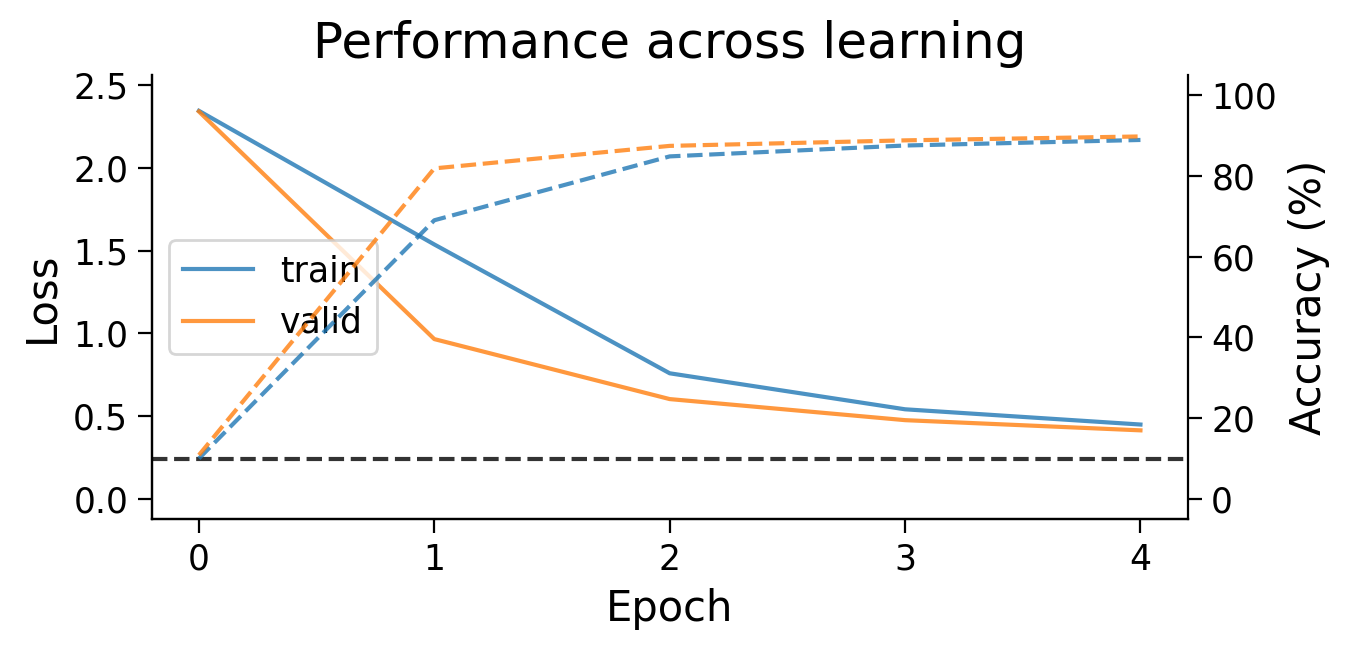

In [ ]:
plot_results(MLP_results_dict);

### 3.2 Final accuracy per class

We can also look at the **accuracy breakdown** per class.

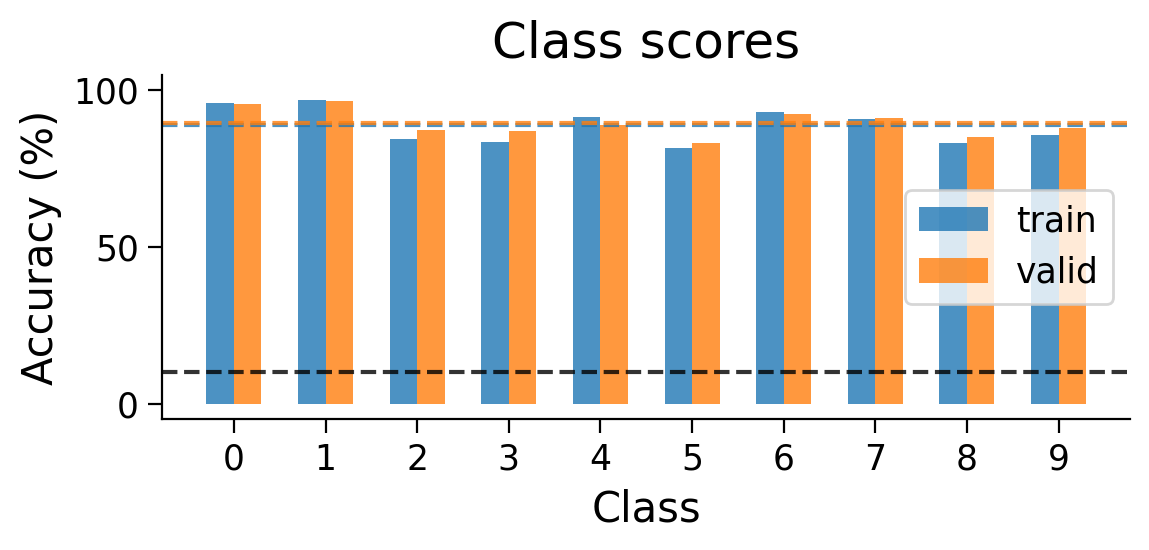

In [ ]:
plot_scores_per_class(MLP_results_dict);

### 3.3 Classified example images

We can **visualize** examples of how the model has classified certain images (correctly or incorrectly).

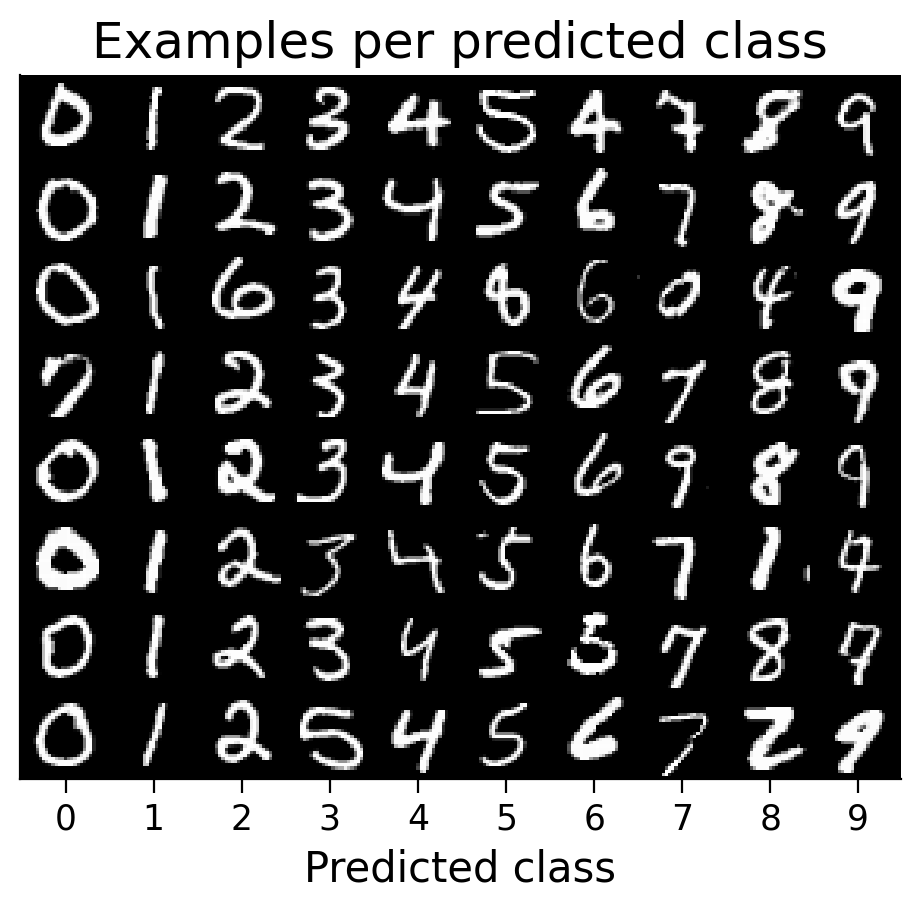

In [ ]:
plot_examples(valid_loader.dataset, MLP=MLP);

### 3.4 Weights before and after learning

We can also observe how the weights changed through learning by visualizing the **initial** weights (top), the weights **after** learning (middle), and the **difference** between the two (bottom).

The average weights **before** learning (dashed line) and **after** learning (full line) are plotted on the colorbar for each layer.

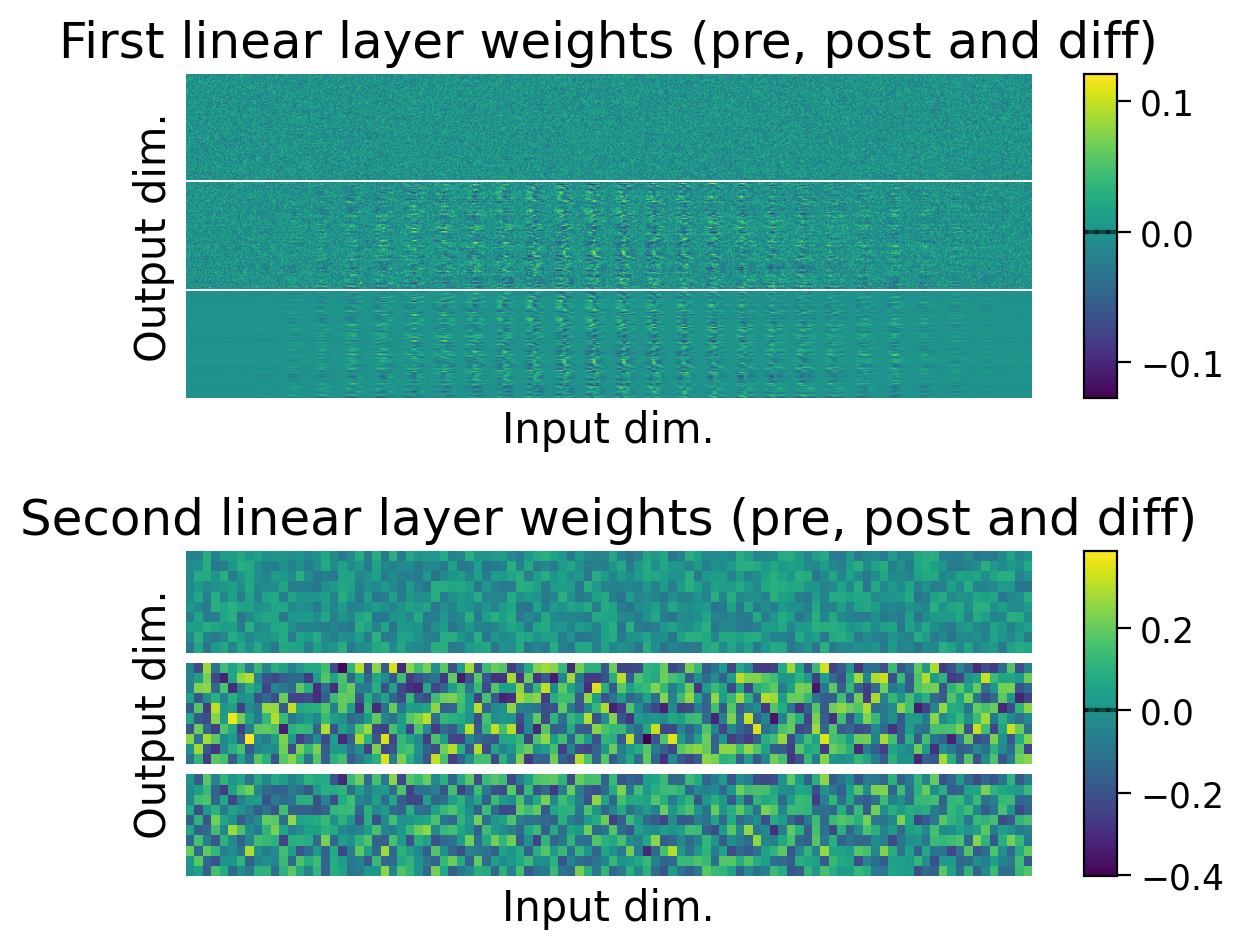

In [ ]:
plot_weights(MLP=MLP);

❓ **What other metrics might you collect or visualize to understand how the model is learning to perform this task?**

**Note:** In this section, we have visualized a variety of metrics that can be used to evaluate and compare models. Later in the project, you may want to **collect and record** these metrics for each trained model, instead of just visualizing the them.

## Section 4. Implementing a biologically plausible learning rule

### 4.1 Hebbian learning

Now, it is time to implement a more biologically plausible learning rule, like **Hebbian learning**. This rule is famously associated with the phrase _"Neurons that fire together wire together."_

In Hebbian learning, the weight $w_{ij}$ between pre-synaptic neuron _i_ and post-synaptic neuron _j_ is updated as follows:  
${\Delta}w_{ij} = {\eta}(a_{i} \cdot a_{j})$,  

where:
- ${\eta}$ is the learning rate,
- $a_{i}$ is the activation of the pre-synaptic neuron _i_, and
- $a_{j}$ is the activation of the post-synaptic neuron _j_.

This means that the **weight update** between two neurons is **proportional to the correlation** in their activity.

In [ ]:
#@markdown Hebbian learning schematic

url = "https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/HebbianLearning.jpeg?raw=true"

display(Image(url = url))

**_(Left)_ Hebbian learning when only positive neural activity is allowed.**  

Input neurons (top) are connected to output neurons (bottom). Active neurons are marked with + (active, light blue) and ++ (very active, dark blue). Connections marked with + will be weakly increased, and those marked with ++ will be strongly increased by Hebbian learning.

**_(Right)_ Hebbian learning when positive and negative neural activity is allowed.**  
Same as (Left), but negatively active neurons are marked with - (slightly active, light red) and -- (very active, dark red). Connections marked with - will be weakly decreased, and those marked with -- will be strongly decreased by Hebbian learning.

#### 4.1.1 Preventing runaway potentiation
Networks trained with Hebbian learning are typically implemented with neurons that only have **positive activations** _(Left)_, like neurons in the brain. This means that weights between neurons can only **increase**.

Allowing neurons to have both **positive and negative** activations _(Right)_ would allow weights to also decrease with Hebbian learning. However, this is not typically done since **negative neural activity** (i.e., a negative firing rate) **is not biologically plausible**.

Instead, various techniques can be used to prevent **runaway potentiation** in Hebbian learning (i.e., weights increasing more and more, without limit). These include normalization techniques like [Oja's rule](http://www.scholarpedia.org/article/Oja_learning_rule). In the example below, we take the approach of simply centering weight updates around 0.

### 4.2 Implementing learning rules in `torch`

#### 4.2.1 Defining a custom autograd function

One way to train a torch model using a learning rule other than backpropagation is to create a **custom autograd function**. With a custom autograd function, we can redefine the `forward()` and `backward()` methods that **pass** activations forward through the network, and pass gradients backward through the network. Specifically, this allows us to specify **how** the gradients used to update the model should be calculated.

To implement Hebbian learning in the model, we will create a **custom autograd function** called `HebbianFunction`.

#### 4.2.2 Defining the `forward()` method

The forward method of an autograd function serves two purposes:  
1) **Compute an output** for the given input.  
2) Gather and store **all the information needed** to compute weight updates during the **backward** pass.

As explained above, to calculate the Hebbian weight change between neurons in two layers, we need the **activity of the input** neurons and the **activity of the output** neurons. So, the `forward()` method should receive **input neuron activity** as its input, and return **output neuron activity** as its output.  

The inputs to `forward()` are therefore:
- `context`: Passed implictly to `forward()`, and used to store any information needed to calculate gradients during the backward pass.
- `input`: The input neuron activity.
- `weight`: The linear layer's weights.
- `bias`: The linear layer's biases (can be `None`).
- `nonlinearity`: The nonlinearity function, as it will be needed to calculate the output neuron's **activity**.
- `target`: As will be explained later, for Hebbian learning, it can be very useful to use the targets to training the last layer of the network, instead of true output activity. So here, if targets are passed to `forward()`, this is stored instead of the output.

In the forward pass, output neuron activity is computed, and the following variables are saved for the backward pass: `input`, `weight`, `bias` and `output_for_update` (i.e., the computed output neuron activity or the `target`, if it's provided, averaged across the batch).

#### 4.2.3 Defining the `backward()` method
The **`backward()`** method of an autograd function computes and returns gradients using only two input variables:
- `context`: In which information was stored during the forward pass.
- `grad_output`: The `grad_input` from the downstream layer (since gradients are computed **backwards** through the network.

Here, for Hebbian learning, we do not use a backpropagated gradient. For this reason, `grad_output` is ignored and no `grad_input` is computed.

Instead, the gradients for the weights and biases are computed using the variables stored in `context`:

- `grad_weight`:
  - Computed as input neuron activity multiplied by output activity.
  - To avoid weight changes scaling linearly with the number of inputs, **we also divide by the number of input neurons**.

- `grad_bias`:
  - Computed simply as the output neuron activity, since biases have the same dimension as the output of a layer.
  - Biases are enabled here. However, it should be noted that although they are used often in networks using error backpropagation, they are not used as often in Hebbian learning.

**Notes:**
- The `backward()` method expects to return **as many gradient values** as the number of **inputs** passed to the `forward()` method (except `context`). It may raise an error if it's not implemented this way. So this is why, in the example below, `backward()` returns `grad_nonlinearity` and `grad_target`, but they are both `None` values.
- The `backward()` method computes the gradients, but **does _not_ apply weight updates**. These are applied when `optimizer.step()` is called. In the `BasicOptimizer`, defined above, the optimizer step optionally applies a weight decay, then subtracts the gradients computed here **multiplied by the learning rate**.
- Standard optimizers, including the `BasicOptimizer`, **expect** to receive error gradients (i.e., values they should **subtract** from the parameters). However, we have computed Hebbian gradients (i.e., values that should be **added** to the parameters). For this reason, the gradients computed are multiplied by `-1` in the `backward()` method before they are returned.

____________________________
To learn more about `torch`'s autograd function and creating custom functions, see the following `torch` documentation and tutorials:
- [A Gentle Introduction to `torch.autograd`](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)
- The **Extending `torch.autograd`** section of [Extending PyTorch](https://pytorch.org/docs/stable/notes/extending.html).
- An [example](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html) of a custom torch autograd function.

In [ ]:
class HebbianFunction(torch.autograd.Function):
  """
  Gradient computing function class for Hebbian learning.
  """

  @staticmethod
  def forward(context, input, weight, bias=None, nonlinearity=None, target=None):
    """
    Forward pass method for the layer. Computes the output of the layer and
    stores variables needed for the backward pass.

    Arguments:
    - context (torch context): context in which variables can be stored for
      the backward pass.
    - input (torch tensor): input to the layer.
    - weight (torch tensor): layer weights.
    - bias (torch tensor, optional): layer biases.
    - nonlinearity (torch functional, optional): nonlinearity for the layer.
    - target (torch tensor, optional): layer target, if applicable.

    Returns:
    - output (torch tensor): layer output.
    """

    # compute the output for the layer (linear layer with non-linearity)
    output = input.mm(weight.t())
    if bias is not None:
      output += bias.unsqueeze(0).expand_as(output)
    if nonlinearity is not None:
      output = nonlinearity(output)

    # calculate the output to use for the backward pass
    output_for_update = output if target is None else target

    # store variables in the context for the backward pass
    context.save_for_backward(input, weight, bias, output_for_update)

    return output

  @staticmethod
  def backward(context, grad_output=None):
    """
    Backward pass method for the layer. Computes and returns the gradients for
    all variables passed to forward (returning None if not applicable).

    Arguments:
    - context (torch context): context in which variables can be stored for
      the backward pass.
    - input (torch tensor): input to the layer.
    - weight (torch tensor): layer weights.
    - bias (torch tensor, optional): layer biases.
    - nonlinearity (torch functional, optional): nonlinearity for the layer.
    - target (torch tensor, optional): layer target, if applicable.

    Returns:
    - grad_input (None): gradients for the input (None, since gradients are not
      backpropagated in Hebbian learning).
    - grad_weight (torch tensor): gradients for the weights.
    - grad_bias (torch tensor or None): gradients for the biases, if they aren't
      None.
    - grad_nonlinearity (None): gradients for the nonlinearity (None, since
      gradients do not apply to the non-linearities).
    - grad_target (None): gradients for the targets (None, since
      gradients do not apply to the targets).
    """

    input, weight, bias, output_for_update = context.saved_tensors
    grad_input = None
    grad_weight = None
    grad_bias = None
    grad_nonlinearity = None
    grad_target = None

    input_needs_grad = context.needs_input_grad[0]
    if input_needs_grad:
      pass

    weight_needs_grad = context.needs_input_grad[1]
    if weight_needs_grad:
      grad_weight = output_for_update.t().mm(input)
      grad_weight = grad_weight / len(input) # average across batch

      # center around 0
      grad_weight = grad_weight - grad_weight.mean(axis=0) # center around 0

      ## or apply Oja's rule (not compatible with clamping outputs to the targets!)
      # oja_subtract = output_for_update.pow(2).mm(grad_weight).mean(axis=0)
      # grad_weight = grad_weight - oja_subtract

      # take the negative, as the gradient will be subtracted
      grad_weight = -grad_weight

    if bias is not None:
      bias_needs_grad = context.needs_input_grad[2]
      if bias_needs_grad:
        grad_bias = output_for_update.mean(axis=0) # average across batch

        # center around 0
        grad_bias = grad_bias - grad_bias.mean()

        ## or apply an adaptation of Oja's rule for biases
        ## (not compatible with clamping outputs to the targets!)
        # oja_subtract = (output_for_update.pow(2) * bias).mean(axis=0)
        # grad_bias = grad_bias - oja_subtract

        # take the negative, as the gradient will be subtracted
        grad_bias = -grad_bias

    return grad_input, grad_weight, grad_bias, grad_nonlinearity, grad_target

#### 4.2.4 Defining a `HebbianMultiLayerPerceptron` class
Lastly, we provide a `HebbianMultiLayerPerceptron` class. This class inherits from `MultiLayerPerceptron`, but implements its own `forward()` method. This `forward()` method uses `HebbianFunction()` to send inputs through each layer of the network and its activation function, ensuring that gradients are computed correctly for Hebbian learning.

In [ ]:
class HebbianMultiLayerPerceptron(MultiLayerPerceptron):
  """
  Hebbian multilayer perceptron with one hidden layer.
  """

  def __init__(self, clamp_output=True, **kwargs):
    """
    Initializes a Hebbian multilayer perceptron object

    Arguments:
    - clamp_output (bool, optional): if True, outputs are clamped to targets,
      if available, when computing weight updates.
    """

    self.clamp_output = clamp_output
    super().__init__(**kwargs)


  def forward(self, X, y=None):
    """
    Runs a forward pass through the network.

    Arguments:
    - X (torch.Tensor): Batch of input images.
    - y (torch.Tensor, optional): Batch of targets, stored for the backward
      pass to compute the gradients for the last layer.

    Returns:
    - y_pred (torch.Tensor): Predicted targets.
    """

    h = HebbianFunction.apply(
        X.reshape(-1, self.num_inputs),
        self.lin1.weight,
        self.lin1.bias,
        self.activation,
    )

    # if targets are provided, they can be used instead of the last layer's
    # output to train the last layer.
    if y is None or not self.clamp_output:
      targets = None
    else:
      targets = torch.nn.functional.one_hot(
          y, num_classes=self.num_outputs
          ).float()

    y_pred = HebbianFunction.apply(
        h,
        self.lin2.weight,
        self.lin2.bias,
        self.softmax,
        targets
    )

    return y_pred

### 4.3 Training a model with Hebbian learning

#### 4.3.1 Simplifying the task to a 2-class task

When implementing biologically plausible learning rules, one often faces a **performance trade-off**. This is because it is often harder for a network to learn without the precise error gradients that error backpropagation offers. More sophisticated designs can really enhance performance. However, since we are starting with the basics, we will instead start by **simplifying** the task from a 10-class task to a 2-class task.

In [ ]:
#@markdown The following function returns a dataset restricted to specific classes:

#@markdown `restrict_classes(dataset)`: Keeps specified classes in a dataset.

def restrict_classes(dataset, classes=[6], keep=True):
  """
  Removes or keeps specified classes in a dataset.

  Arguments:
  - dataset (torch dataset or subset): Dataset with class targets.
  - classes (list): List of classes to keep or remove.
  - keep (bool): If True, the classes specified are kept. If False, they are
  removed.

  Returns:
  - new_dataset (torch dataset or subset): Datset restricted as specified.
  """

  if hasattr(dataset, "dataset"):
    indices = np.asarray(dataset.indices)
    targets = dataset.dataset.targets[indices]
    dataset = dataset.dataset
  else:
    indices = np.arange(len(dataset))
    targets = dataset.targets

  specified_idxs = np.isin(targets, np.asarray(classes))
  if keep:
    retain_indices = indices[specified_idxs]
  else:
    retain_indices = indices[~specified_idxs]

  new_dataset = torch.utils.data.Subset(dataset, retain_indices)

  return new_dataset

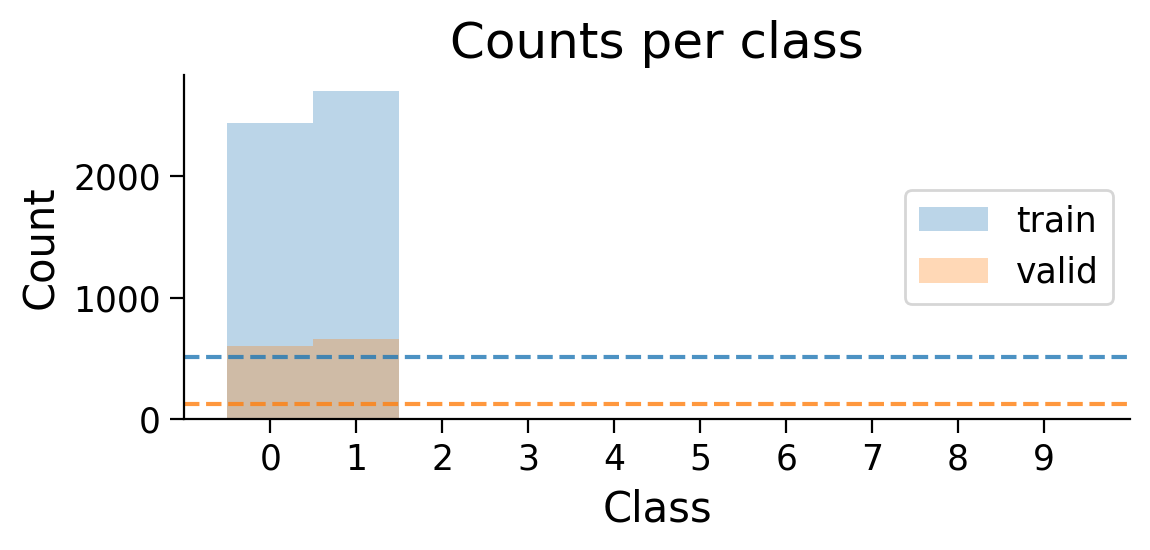

In [ ]:
train_set_2_classes = restrict_classes(train_set, [0, 1])
valid_set_2_classes = restrict_classes(valid_set, [0, 1])

plot_class_distribution(train_set_2_classes, valid_set_2_classes)

train_loader_2cls = torch.utils.data.DataLoader(train_set_2_classes, batch_size=BATCH_SIZE, shuffle=True)
valid_loader_2cls = torch.utils.data.DataLoader(valid_set_2_classes, batch_size=BATCH_SIZE, shuffle=False)

The number of examples for each class in the training and validation sets are shown. Dashed lines show what counts would be expected if there were the same number of examples in each class.

#### 4.3.2 Training on a 2-class task

We'll test the Hebbian learning model's performance with `10` epochs of training.

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:09,  1.03s/it]

 20%|██        | 2/10 [00:02<00:08,  1.07s/it]

 30%|███       | 3/10 [00:03<00:07,  1.08s/it]

 40%|████      | 4/10 [00:04<00:06,  1.09s/it]

 50%|█████     | 5/10 [00:05<00:05,  1.09s/it]

 60%|██████    | 6/10 [00:06<00:04,  1.10s/it]

 70%|███████   | 7/10 [00:07<00:03,  1.10s/it]

 80%|████████  | 8/10 [00:08<00:02,  1.10s/it]

 90%|█████████ | 9/10 [00:09<00:01,  1.10s/it]

100%|██████████| 10/10 [00:10<00:00,  1.10s/it]

100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

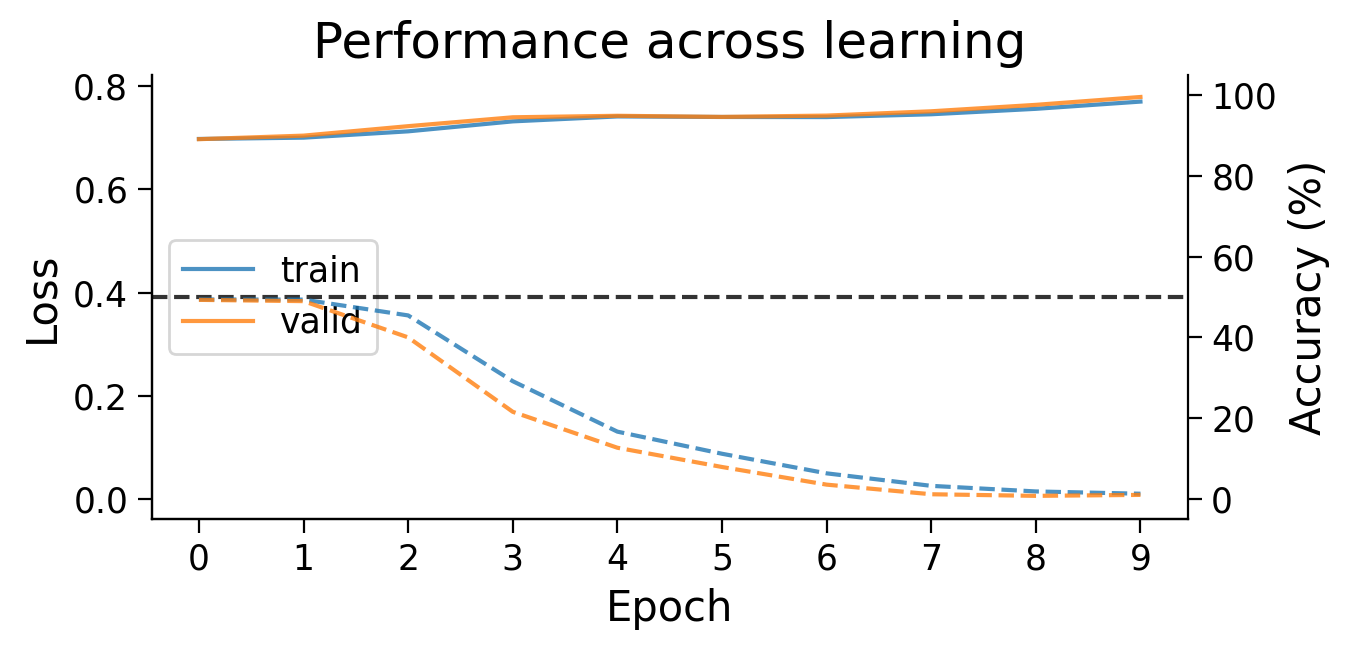

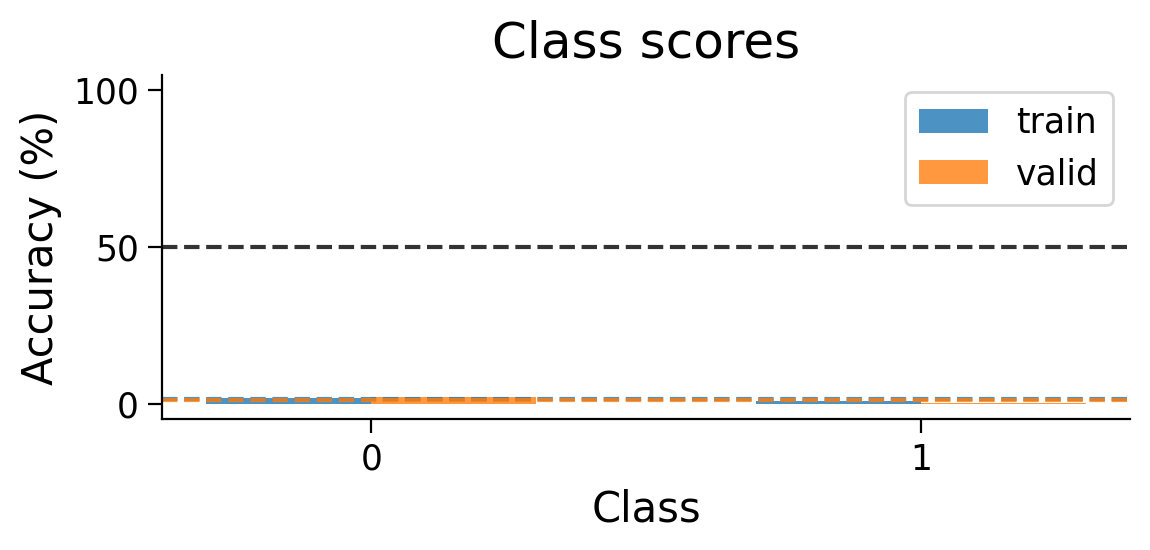

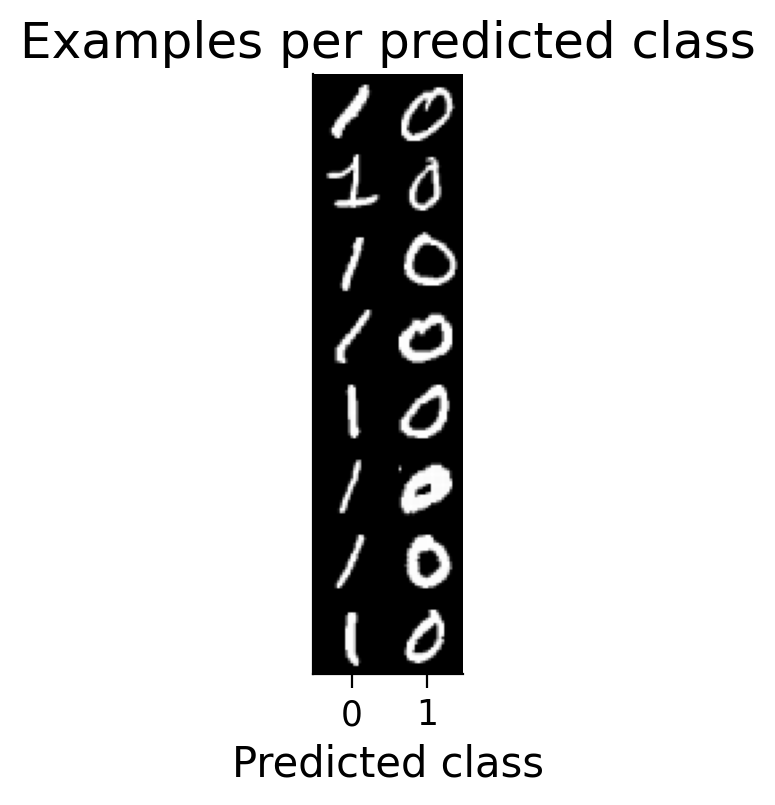

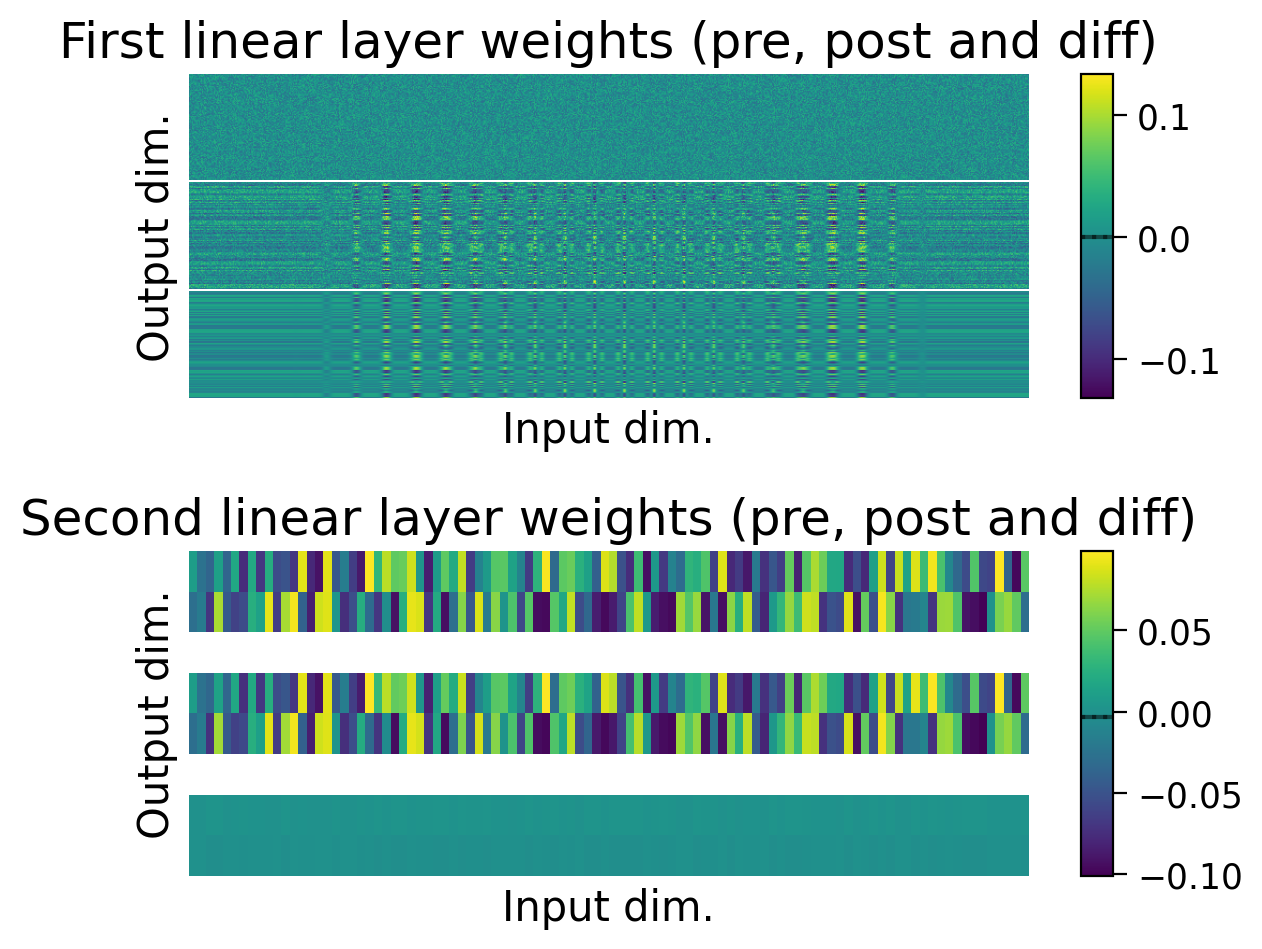

In [ ]:
HEBB_LR = 1e-4 # lower, since Hebbian gradients are much bigger than backprop gradients

HebbianMLP_2cls = HebbianMultiLayerPerceptron(
    num_hidden=NUM_HIDDEN,
    num_outputs=2,
    clamp_output=False,
)

Hebb_optimizer_2cls = BasicOptimizer(HebbianMLP_2cls.parameters(), lr=HEBB_LR)

Hebb_results_dict_2cls = train_model(
    HebbianMLP_2cls,
    train_loader_2cls,
    valid_loader_2cls,
    Hebb_optimizer_2cls,
    num_epochs=10
    );

plot_results(Hebb_results_dict_2cls, num_classes=2)
plot_scores_per_class(Hebb_results_dict_2cls, num_classes=2)
plot_examples(valid_loader_2cls.dataset, MLP=HebbianMLP_2cls, num_classes=2)
plot_weights(HebbianMLP_2cls);

Try running the previous cell **several times** to see how often the model succeeds in learning this simple classification task.

❓ **Why does this network struggle to learn this simple classification task?**

#### 4.3.3 Training with targets

As you may have notice, the classification **targets** do not actually appear in the basic Hebbian learning rule. How, then, can the network learn to perform a supervised task?

To allow a network trained with Hebbian learning to learn a supervised task, one can take the approach of **clamping the outputs to the targets**. In other words, we can update the final layer's weights using the targets $t_{j}$ instead of the final layer's activations $a_{j}$.

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:09,  1.04s/it]

 20%|██        | 2/10 [00:02<00:08,  1.08s/it]

 30%|███       | 3/10 [00:03<00:07,  1.09s/it]

 40%|████      | 4/10 [00:04<00:06,  1.10s/it]

 50%|█████     | 5/10 [00:05<00:05,  1.11s/it]

 60%|██████    | 6/10 [00:06<00:04,  1.10s/it]

 70%|███████   | 7/10 [00:07<00:03,  1.11s/it]

 80%|████████  | 8/10 [00:08<00:02,  1.11s/it]

 90%|█████████ | 9/10 [00:09<00:01,  1.11s/it]

100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

100%|██████████| 10/10 [00:11<00:00,  1.10s/it]

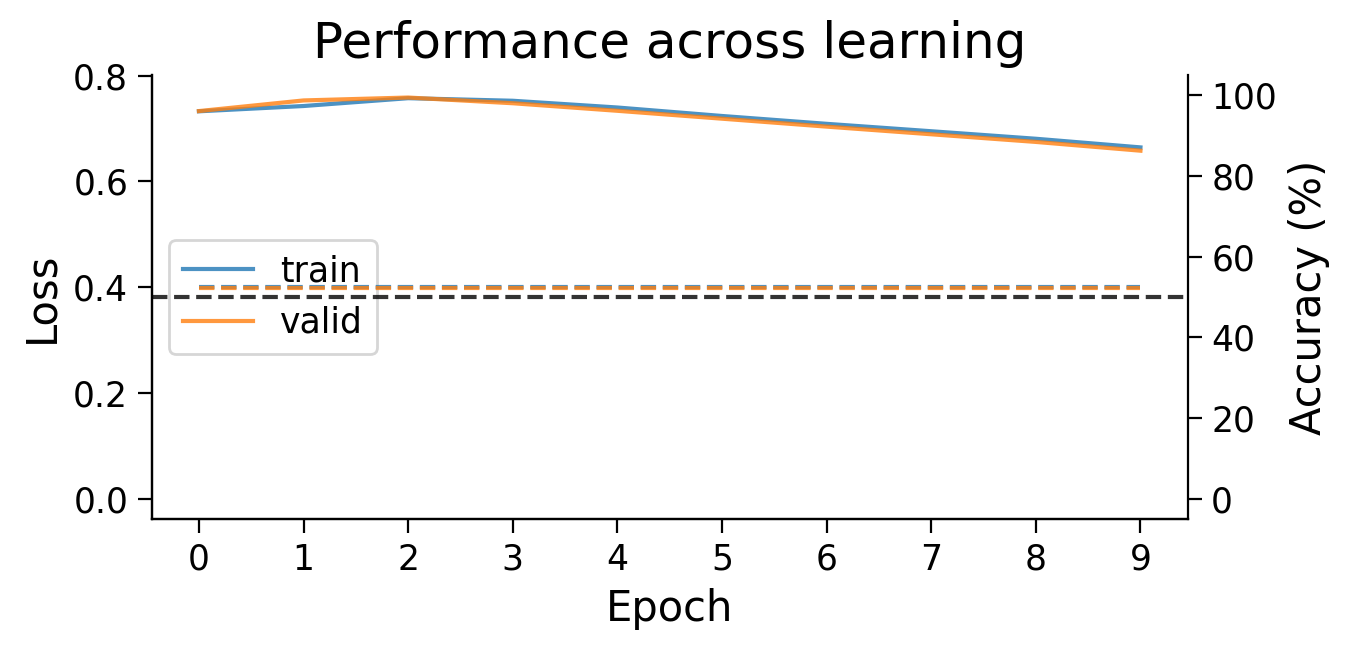

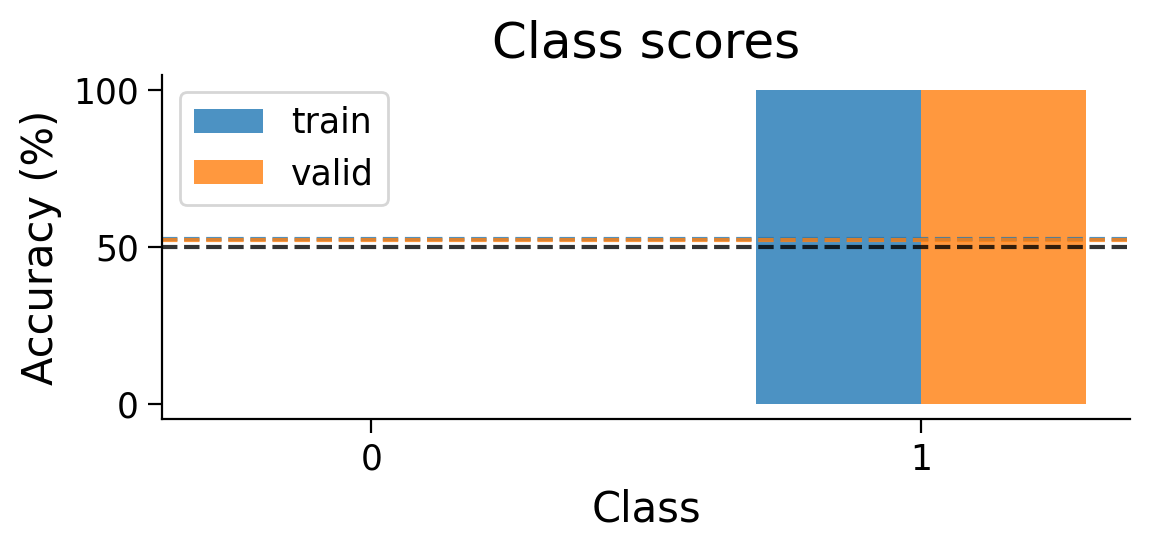

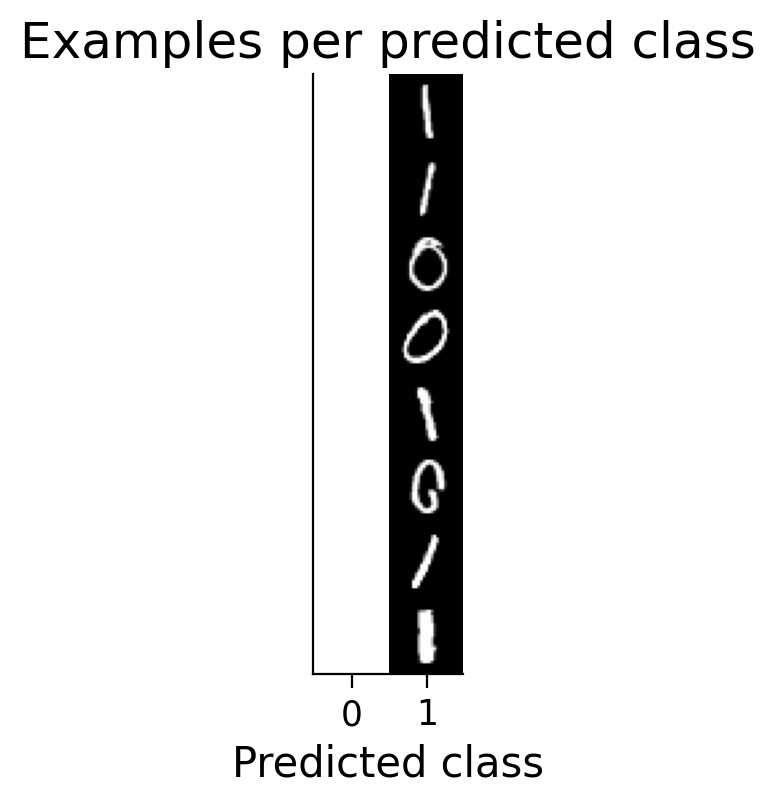

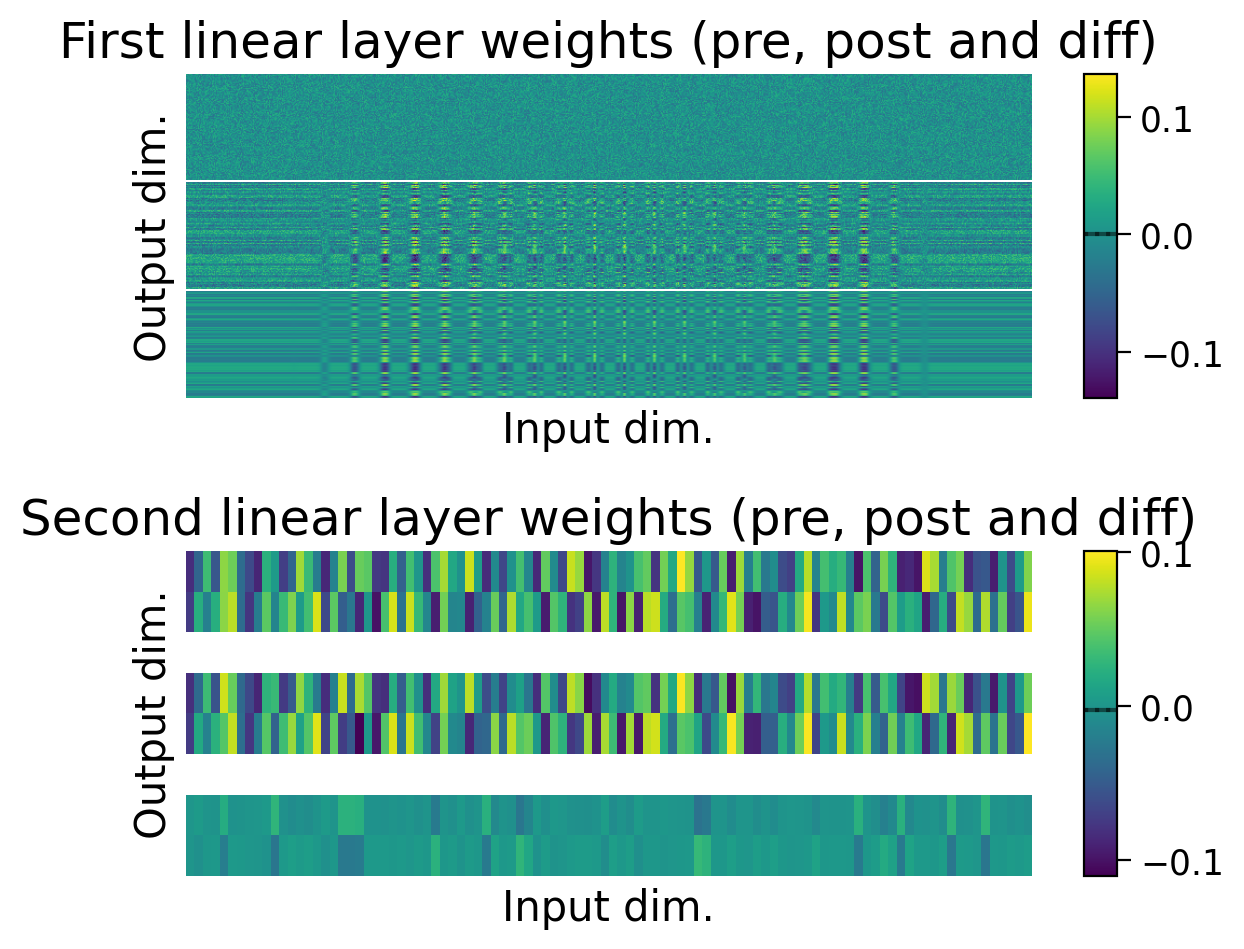

In [ ]:
HebbianMLP_2cls = HebbianMultiLayerPerceptron(
    num_hidden=NUM_HIDDEN,
    num_outputs=2,
    clamp_output=True, # clamp output to targets
)

Hebb_optimizer_2cls = BasicOptimizer(HebbianMLP_2cls.parameters(), lr=HEBB_LR)

Hebb_results_dict_2cls = train_model(
    HebbianMLP_2cls,
    train_loader_2cls,
    valid_loader_2cls,
    Hebb_optimizer_2cls,
    num_epochs=10
    );

plot_results(Hebb_results_dict_2cls, num_classes=2)
plot_scores_per_class(Hebb_results_dict_2cls, num_classes=2)
plot_examples(valid_loader_2cls.dataset, MLP=HebbianMLP_2cls, num_classes=2)
plot_weights(HebbianMLP_2cls);

Try running the previous cell **several times**. The model should now be more successful at learning this simple classification task.

❓ **Is the model successful every time? If not, what might be contributing to the variability in performance?**  
❓ **Going futher: How does changing the training hyperparameters (learning rate and number of epochs) affect network learning?**

**Note:** The clamped outputs setting _cannot_ be used with Oja's rule (i.e., one of the Hebbian learning modifications used to prevent runaway weight increases). This is because the values subtracted when using Oja's rule would be calculated on the target outputs instead of the actual outputs, and these values would end up being too big.  

#### 4.3.4 Increasing task difficulty

Next, let's see what happens when we **increase the number of classes** in the task. The following function handles the entire initialization and training process:

In [ ]:
#@markdown `train_model_extended`: Initializes model and optimizer, restricts datasets to
#@markdown specified classes, trains model. Returns trained model and results dictionary.

def train_model_extended(model_type="backprop", keep_num_classes="all", lr=LR,
                         num_epochs=5, partial_backprop=False,
                         num_hidden=NUM_HIDDEN, bias=BIAS,
                         batch_size=BATCH_SIZE, plot_distribution=False):
  """
  Initializes model and optimizer, restricts datasets to specified classes and
  trains the model. Returns the trained model and results dictionary.

  Arguments:
  - model_type (str, optional): model to initialize ("backprop" or "Hebbian")
  - keep_num_classes (str or int, optional): number of classes to keep (from 0)
  - lr (float or list, optional): learning rate for both or each layer
  - num_epochs (int, optional): number of epochs to train model.
  - partial_backprop (bool, optional): if True, backprop is used to train the
    final Hebbian learning model.
  - num_hidden (int, optional): number of hidden units in the hidden layer
  - bias (bool, optional): if True, each linear layer will have biases in
      addition to weights.
  - batch_size (int, optional): batch size for dataloaders.
  - plot_distribution (bool, optional): if True, dataset class distributions
    are plotted.

  Returns:
  - MLP (torch module): Model
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  """

  if isinstance(keep_num_classes, str):
    if keep_num_classes == "all":
      num_classes = 10
      use_train_set = train_set
      use_valid_set = valid_set
    else:
      raise ValueError("If 'keep_classes' is a string, it should be 'all'.")
  else:
    num_classes = int(keep_num_classes)
    use_train_set = restrict_classes(train_set, np.arange(keep_num_classes))
    use_valid_set = restrict_classes(valid_set, np.arange(keep_num_classes))

  if plot_distribution:
    plot_class_distribution(use_train_set, use_valid_set)

  train_loader = torch.utils.data.DataLoader(
      use_train_set, batch_size=batch_size, shuffle=True
      )
  valid_loader = torch.utils.data.DataLoader(
      use_valid_set, batch_size=batch_size, shuffle=False
        )

  model_params = {
      "num_hidden": num_hidden,
      "num_outputs": num_classes,
      "bias": bias,
  }

  if model_type.lower() == "backprop":
    Model = MultiLayerPerceptron
  elif model_type.lower() == "hebbian":
    if partial_backprop:
      Model = HebbianBackpropMultiLayerPerceptron
    else:
      Model = HebbianMultiLayerPerceptron
      model_params["clamp_output"] = True
  else:
    raise ValueError(
        f"Got {model_type} model type, but expected 'backprop' or 'hebbian'."
        )

  MLP = Model(**model_params)

  if isinstance(lr, list):
    if len(lr) != 2:
      raise ValueError("If 'lr' is a list, it must be of length 2.")
    optimizer = BasicOptimizer([
        {"params": MLP.lin1.parameters(), "lr": lr[0]},
        {"params": MLP.lin2.parameters(), "lr": lr[1]},
    ])
  else:
    optimizer = BasicOptimizer(MLP.parameters(), lr=lr)


  results_dict = train_model(
      MLP,
      train_loader,
      valid_loader,
      optimizer,
      num_epochs=num_epochs
      )

  return MLP, results_dict

First, let's train a model on this task using error backpropagation.

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:01<00:06,  1.53s/it]

 40%|████      | 2/5 [00:03<00:04,  1.58s/it]

 60%|██████    | 3/5 [00:04<00:03,  1.60s/it]

 80%|████████  | 4/5 [00:06<00:01,  1.61s/it]

100%|██████████| 5/5 [00:08<00:00,  1.62s/it]

100%|██████████| 5/5 [00:08<00:00,  1.61s/it]

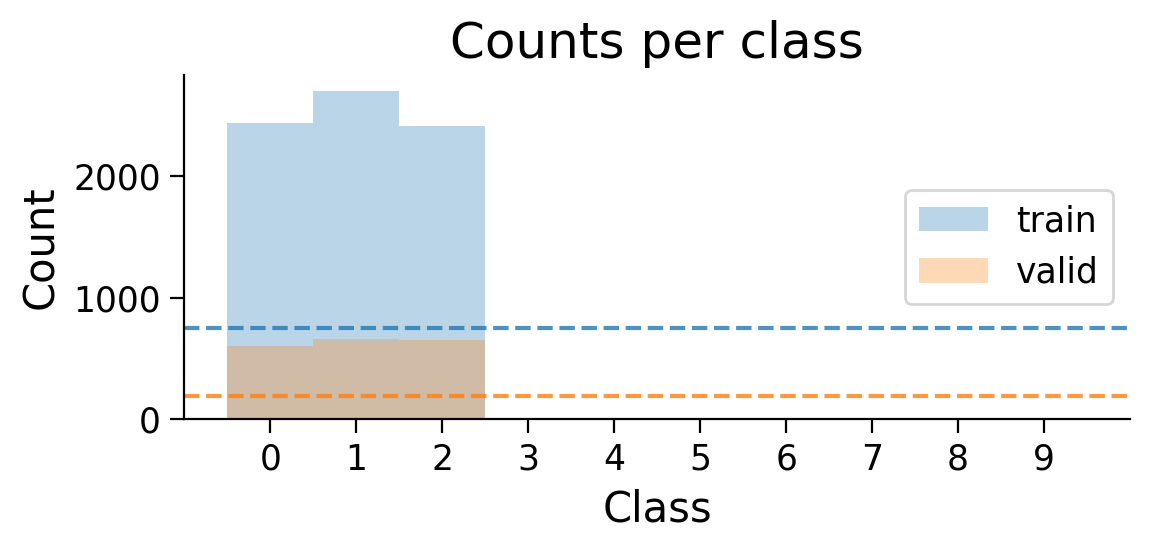

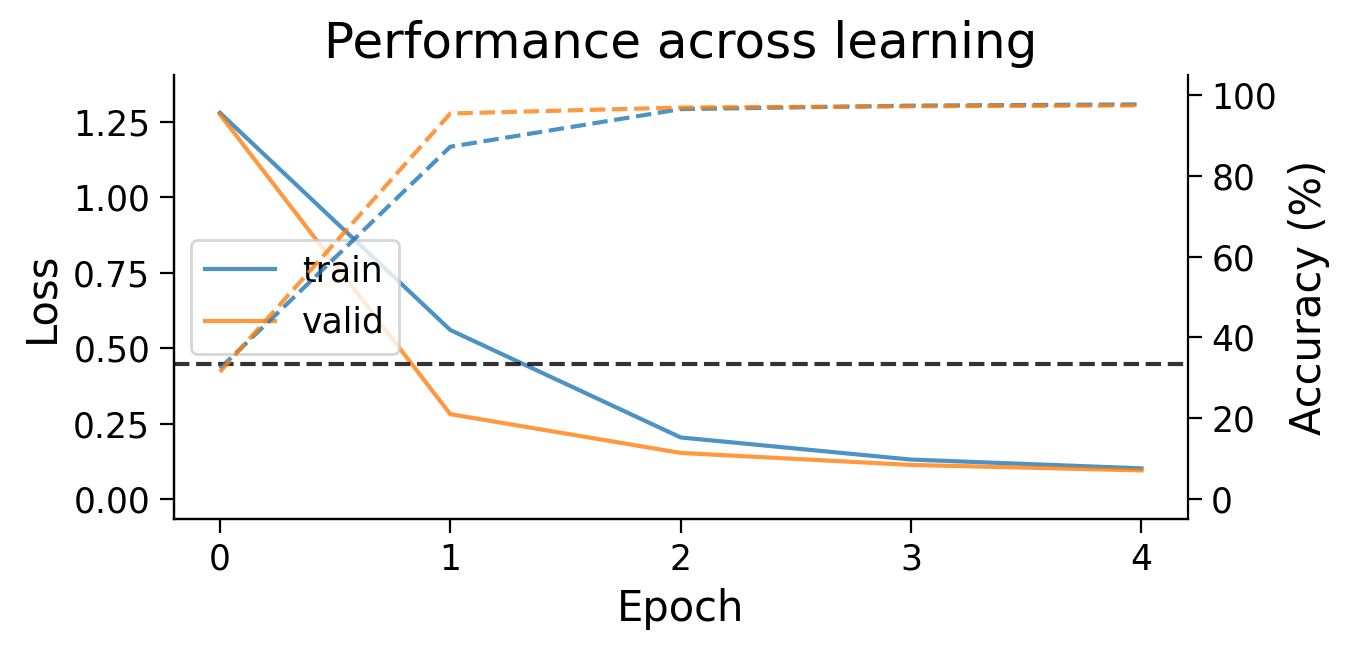

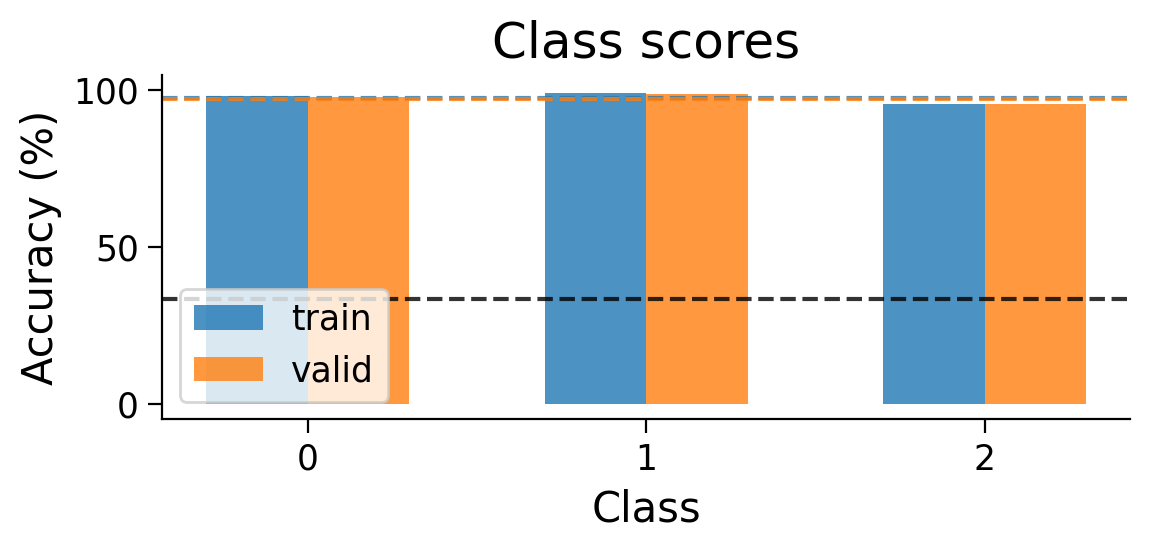

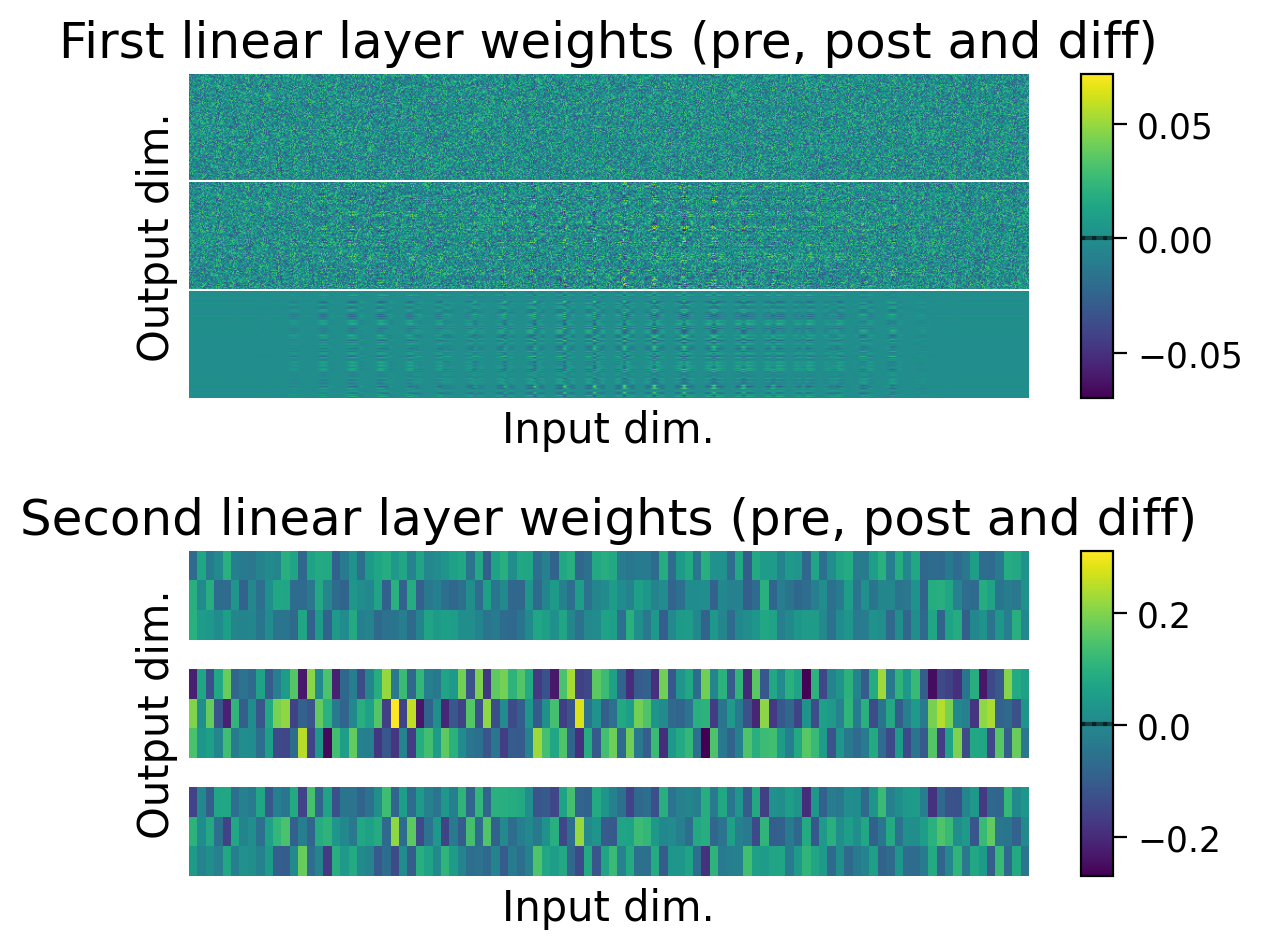

In [ ]:
MLP_3cls, results_dict_3cls = train_model_extended(
    model_type="backprop",
    keep_num_classes=3,
    num_epochs=5,
    lr=LR,
    plot_distribution=True,
)

plot_results(results_dict_3cls, num_classes=3)
plot_scores_per_class(results_dict_3cls, num_classes=3)
plot_weights(MLP_3cls);

Now, let's try training a model with Hebbian learning (and outputs clamped to targets). Since the task is harder, we'll increase the number of training epochs to `15`.

  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:01<00:21,  1.55s/it]

 13%|█▎        | 2/15 [00:03<00:20,  1.61s/it]

 20%|██        | 3/15 [00:04<00:19,  1.63s/it]

 27%|██▋       | 4/15 [00:06<00:17,  1.63s/it]

 33%|███▎      | 5/15 [00:08<00:16,  1.64s/it]

 40%|████      | 6/15 [00:09<00:14,  1.64s/it]

 47%|████▋     | 7/15 [00:11<00:13,  1.64s/it]

 53%|█████▎    | 8/15 [00:13<00:11,  1.64s/it]

 60%|██████    | 9/15 [00:14<00:09,  1.64s/it]

 67%|██████▋   | 10/15 [00:16<00:08,  1.63s/it]

 73%|███████▎  | 11/15 [00:17<00:06,  1.63s/it]

 80%|████████  | 12/15 [00:19<00:04,  1.63s/it]

 87%|████████▋ | 13/15 [00:21<00:03,  1.63s/it]

 93%|█████████▎| 14/15 [00:22<00:01,  1.63s/it]

100%|██████████| 15/15 [00:24<00:00,  1.64s/it]

100%|██████████| 15/15 [00:24<00:00,  1.63s/it]

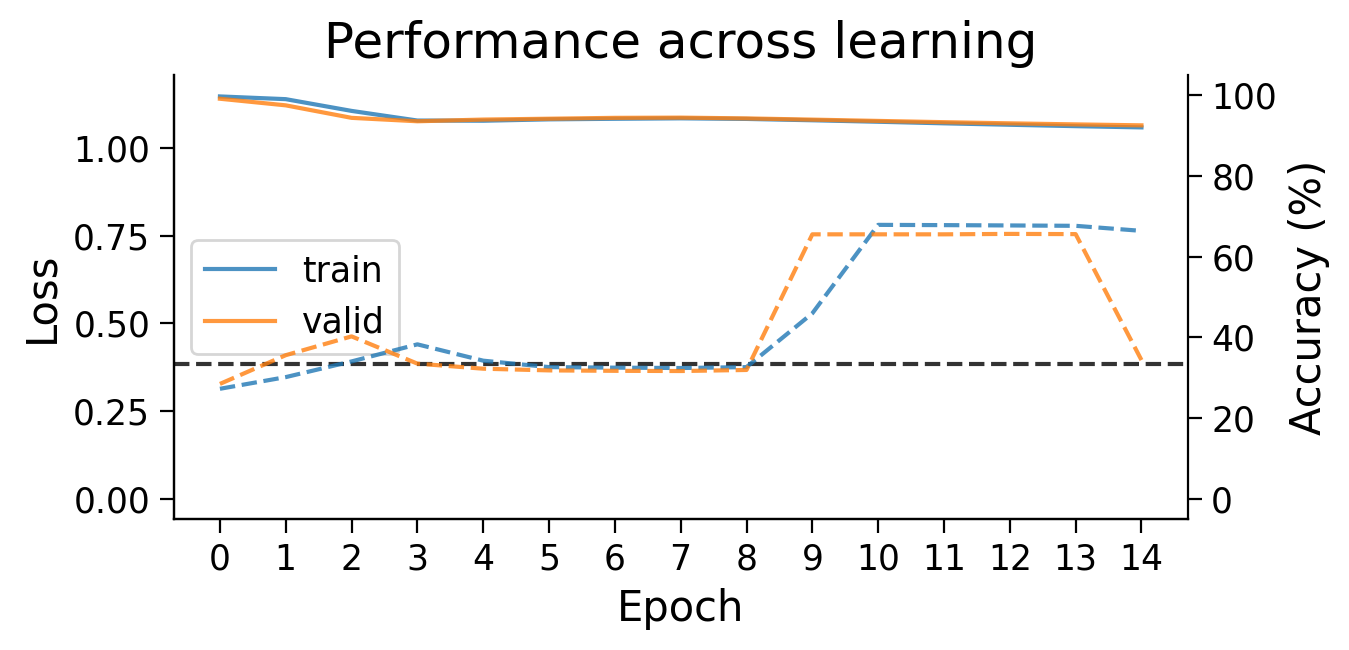

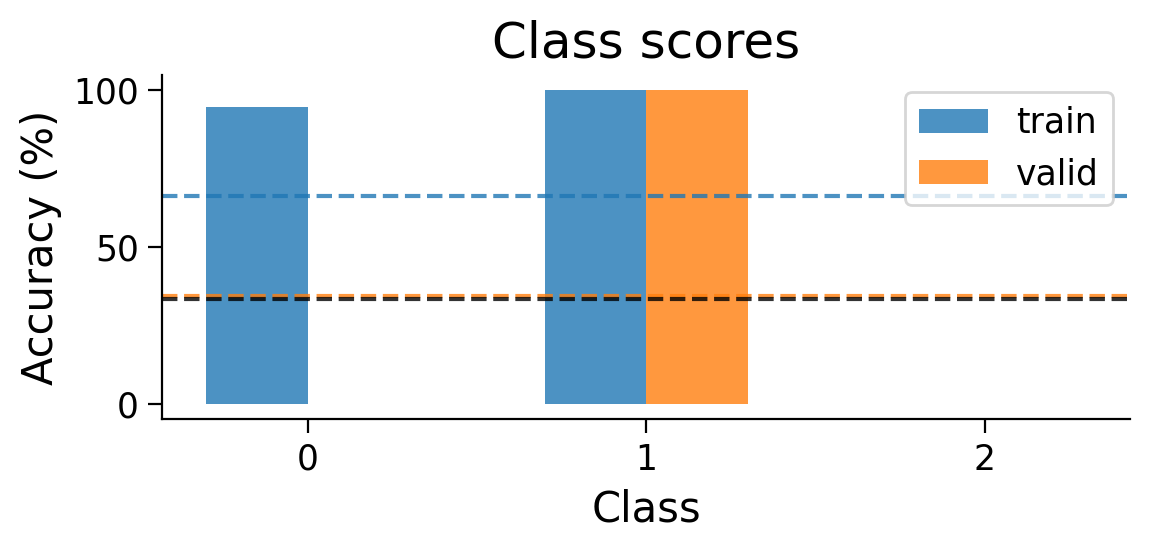

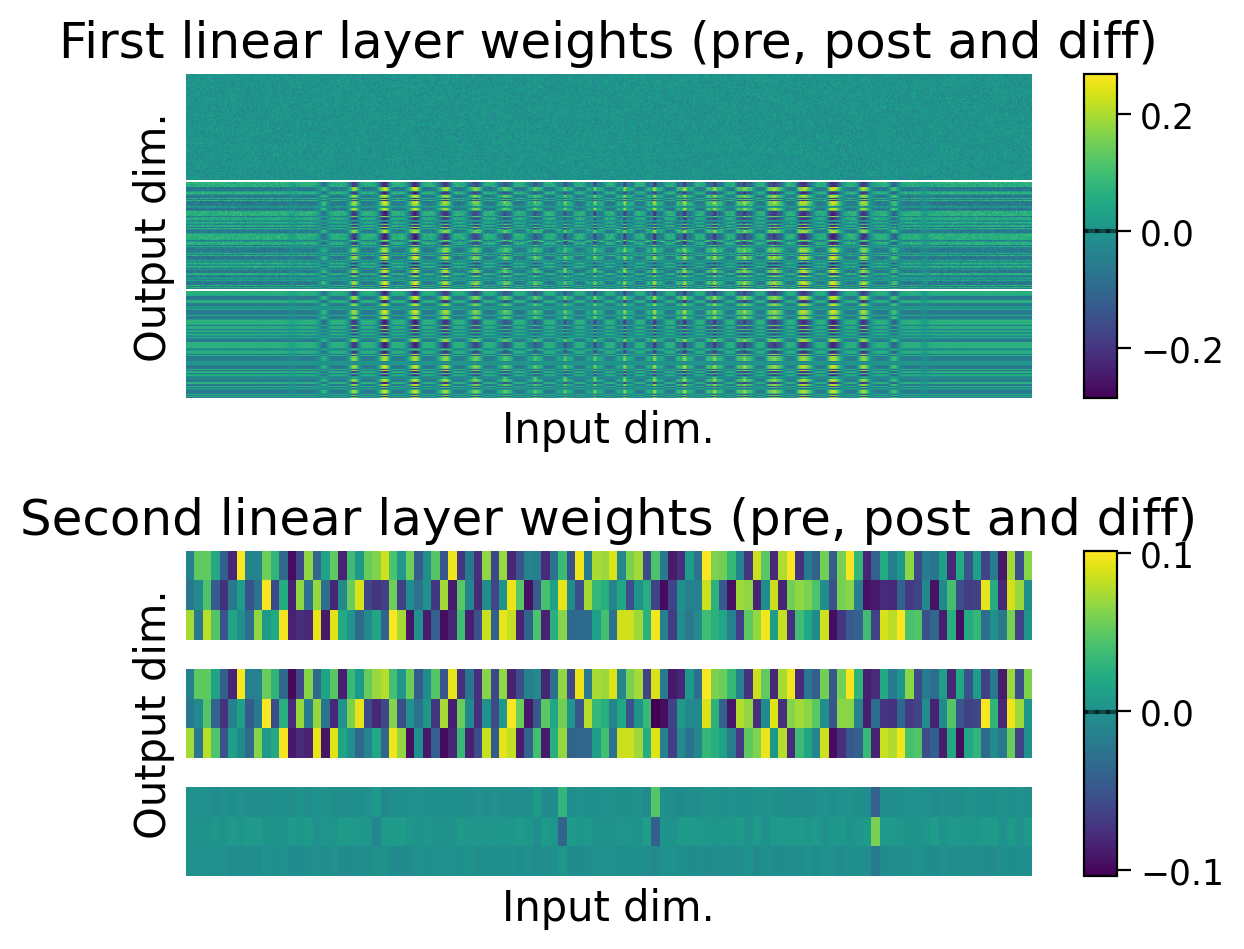

In [ ]:
HebbianMLP_3cls, Hebbian_results_dict_3cls = train_model_extended(
    model_type="hebbian",
    keep_num_classes=3,
    num_epochs=15,
    lr=HEBB_LR,
)

plot_results(Hebbian_results_dict_3cls, num_classes=3)
plot_scores_per_class(Hebbian_results_dict_3cls, num_classes=3)
plot_weights(HebbianMLP_3cls);

Try running the previous cell a few times to see how often the model is successful.

❓ **How is the model learning in each layer?**  
❓ **How do the weight updates learned with Hebbian learning compare to those learned with error backpropagation?**

We can try using **different learning rates** to encourage more learning in the second layer.

  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:01<00:21,  1.56s/it]

 13%|█▎        | 2/15 [00:03<00:20,  1.61s/it]

 20%|██        | 3/15 [00:04<00:19,  1.63s/it]

 27%|██▋       | 4/15 [00:06<00:18,  1.64s/it]

 33%|███▎      | 5/15 [00:08<00:16,  1.64s/it]

 40%|████      | 6/15 [00:09<00:14,  1.64s/it]

 47%|████▋     | 7/15 [00:11<00:13,  1.64s/it]

 53%|█████▎    | 8/15 [00:13<00:11,  1.63s/it]

 60%|██████    | 9/15 [00:14<00:09,  1.64s/it]

 67%|██████▋   | 10/15 [00:16<00:08,  1.64s/it]

 73%|███████▎  | 11/15 [00:18<00:06,  1.64s/it]

 80%|████████  | 12/15 [00:19<00:04,  1.65s/it]

 87%|████████▋ | 13/15 [00:21<00:03,  1.65s/it]

 93%|█████████▎| 14/15 [00:22<00:01,  1.65s/it]

100%|██████████| 15/15 [00:24<00:00,  1.65s/it]

100%|██████████| 15/15 [00:24<00:00,  1.64s/it]

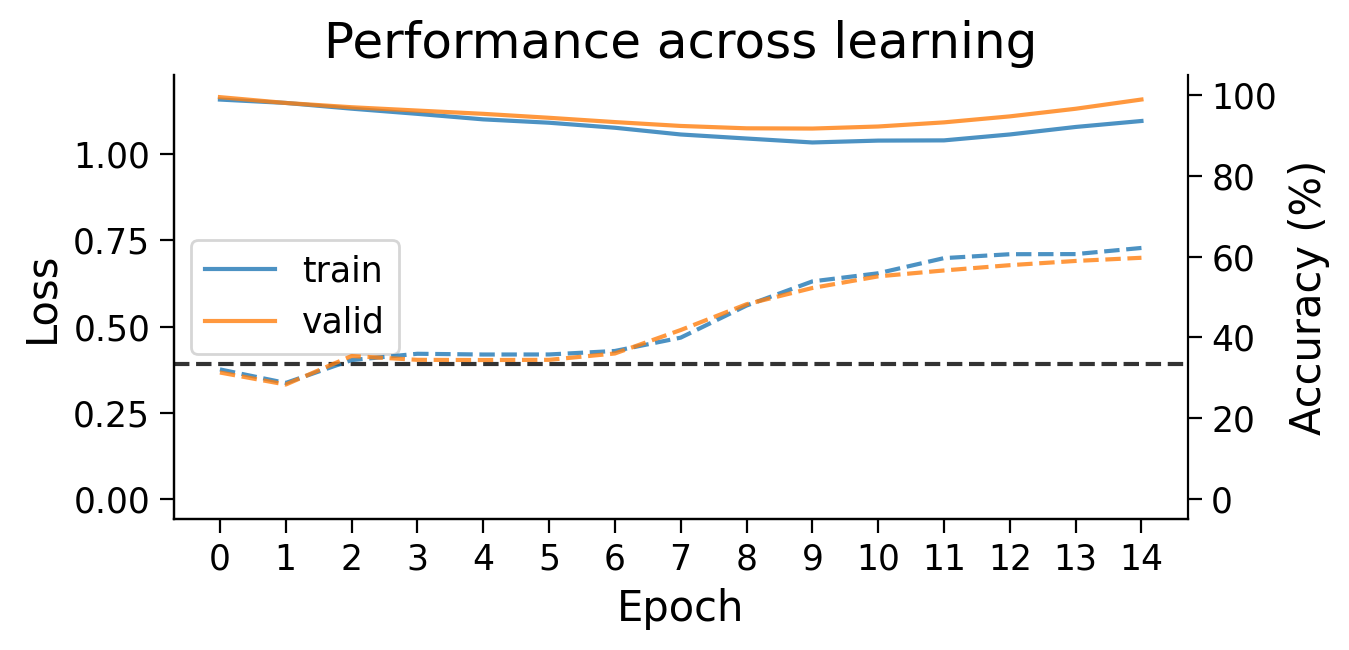

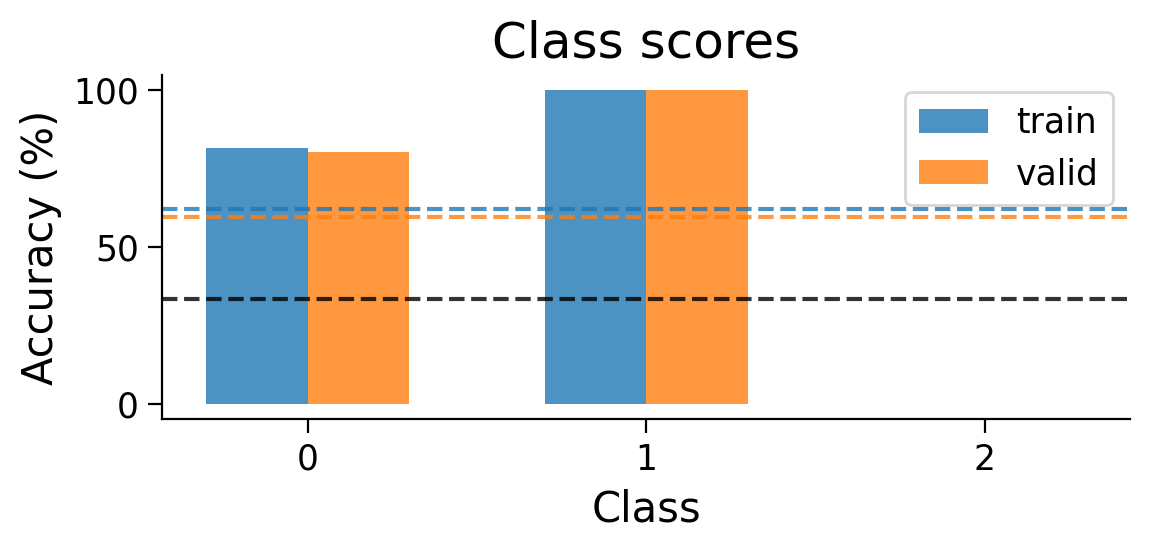

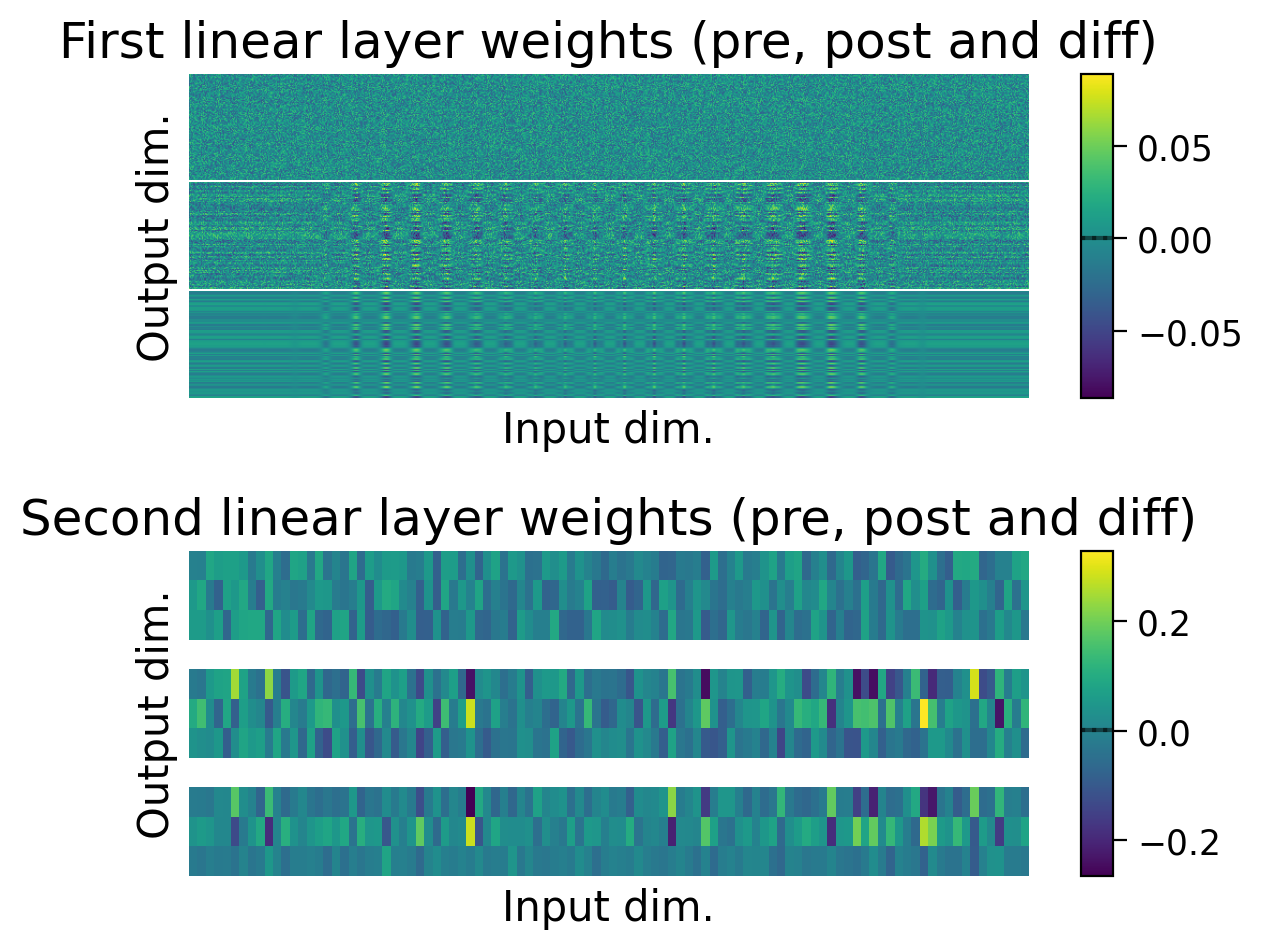

In [ ]:
HebbianMLP_3cls, Hebbian_results_dict_3cls = train_model_extended(
    model_type="hebbian",
    keep_num_classes=3,
    num_epochs=15,
    lr=[HEBB_LR / 4, HEBB_LR * 8], # learning rate for each layer
)

plot_results(Hebbian_results_dict_3cls, num_classes=3)
plot_scores_per_class(Hebbian_results_dict_3cls, num_classes=3)
plot_weights(HebbianMLP_3cls);

Performance tends to be highly variable and unstable. At best, the network is able to classify 2 classes, but generally not all 3 classes.

#### 4.3.5 Combining Hebbian learning and error backpropagation

What happens if we use Hebbian learning for the first layer, but use error backpropagation to train the second layer?

In [ ]:
#@markdown `HebbianBackpropMultiLayerPerceptron()`: Class combining Hebbian learning and backpropagation.

class HebbianBackpropMultiLayerPerceptron(MultiLayerPerceptron):
  """
  Hybrid backprop/Hebbian multilayer perceptron with one hidden layer.
  """

  def forward(self, X, y=None):
    """
    Runs a forward pass through the network.

    Arguments:
    - X (torch.Tensor): Batch of input images.
    - y (torch.Tensor, optional): Batch of targets, not used here.

    Returns:
    - y_pred (torch.Tensor): Predicted targets.
    """

    # Hebbian layer
    h = HebbianFunction.apply(
        X.reshape(-1, self.num_inputs),
        self.lin1.weight,
        self.lin1.bias,
        self.activation,
    )

    # backprop layer
    y_pred = self.softmax(self.lin2(h))

    return y_pred

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:05<00:20,  5.11s/it]

 40%|████      | 2/5 [00:10<00:15,  5.27s/it]

 60%|██████    | 3/5 [00:15<00:10,  5.33s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.38s/it]

100%|██████████| 5/5 [00:26<00:00,  5.40s/it]

100%|██████████| 5/5 [00:26<00:00,  5.36s/it]

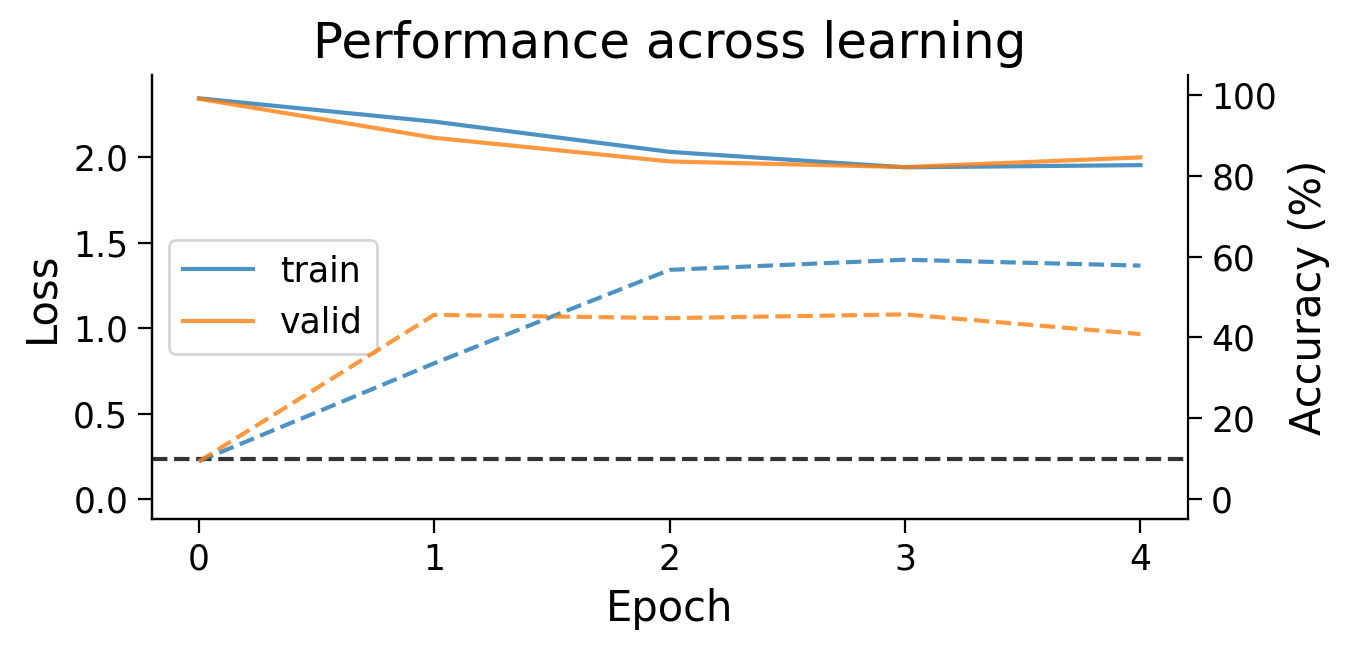

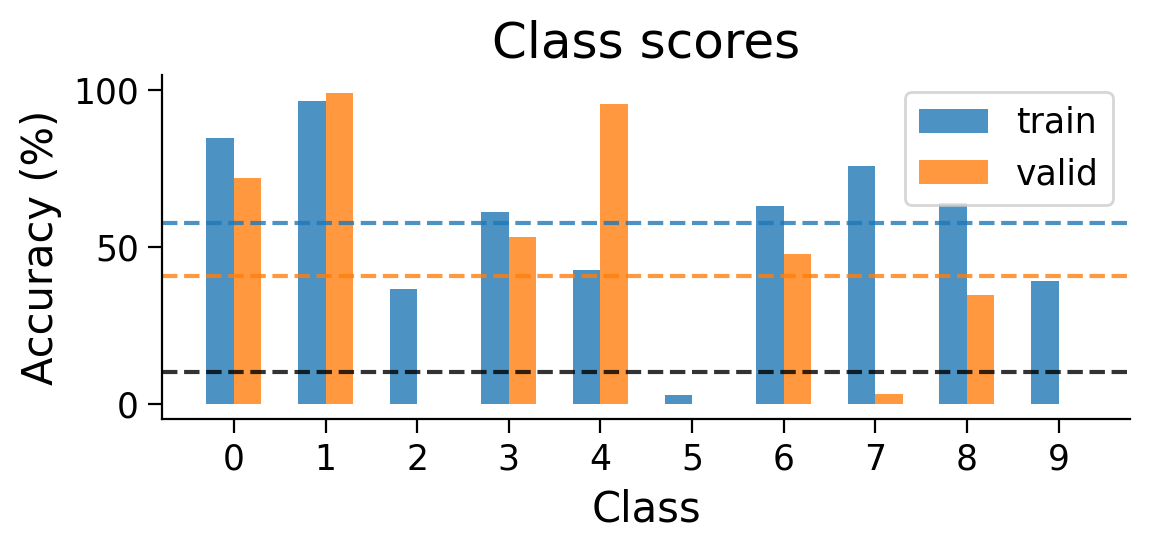

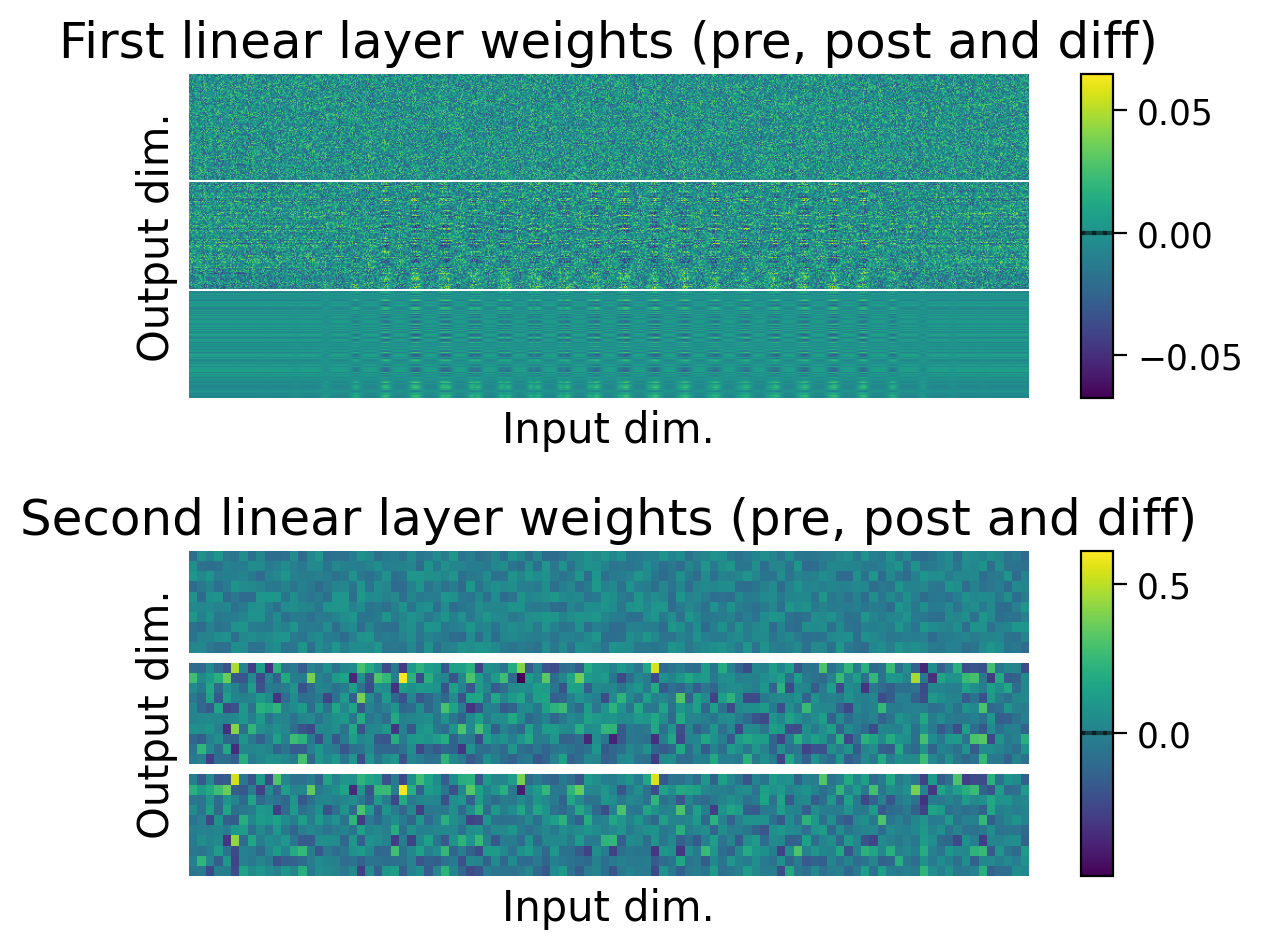

In [ ]:
HybridMLP, Hybrid_results_dict = train_model_extended(
    model_type="hebbian",
    num_epochs=5,
    partial_backprop=True, # backprop on the final layer
    lr=[HEBB_LR / 5, LR], # learning rates for each layer
)

plot_results(Hybrid_results_dict)
plot_scores_per_class(Hybrid_results_dict)
plot_weights(HybridMLP);

Using Hebbian learning and error backpropagation allows us to achieve above chance performance on the the full MNIST classification task, though performance is still much lower than when using error backpropagation on its own.

❓ **What are some of the properties of Hebbian learning that might explain its weaker performance on this task when compared to error backpropagation?**   
❓ **Going further: Are there tasks that Hebbian learning might be better at than error backpropagation?**  

### Section 4.4. Computing the variance and bias of a model's gradients.

To better understand _how_ a model trained with a biologically plausible learning rule (e.g., Hebbian learning) learns, it can be useful to compare its learning to error backpropagation. Specifically, we can compare the gradients computed with both learning rules to one another.

### Variance

One property we can compute is the variance. The variance tells us **how consistent** are the gradients obtained for each weight **across examples** when computed with one learning rule compared to the other. We might expect a good learning rule to be more consistent, and therefore have **lower variance** in its gradients (_left_ column in the bullseye image).

However, it would be unfair to compare the variance of small gradients (like those computed with error backpropagation) with the variance of large gradients (like those computed with Hebbian learning). So, we will estimate variance in the gradients using a **scale-invariant** measure: the **signal-to-noise ratio (SNR)**. Note that **high SNR** corresponds to **low variance**, and vice versa.

### Bias
Another property we can compute is how biased gradients computed with a specific learning rule are with respect to **ideal gradients**. Now, since the ideal gradients for learning a task are generally unknown, we need to estimate them. We can do so using error backpropagation, as it is the best algorithm we know for learning a task along the gradient of its error. A good learning rule would then be expected to have **low bias** in its gradients with respect to error backpropagation gradients.

As with the variance, our bias estimate should be **scale-invariant**, so we will estimate it using the Cosine similarity. Note that **high Cosine similarity** with error backpropagation gradients corresponds to **low bias**, and vice versa.

In [ ]:
#@markdown Bias and variance schematic

url = "https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/BiasVariance.jpeg?raw=true"

display(Image(url = url))

The bullseye image illustrates the differences and interplay between bias and variance in a variable. In the **left column**, the variable being measured shows **low variance**, as the green dots are densely concentrated. In the **right column**, the dots are more dispersed, reflecting a higher variance.

Although the examples in each column show the same variance, they show different biases. In examples in the **top row**, the variable being measured has a **low bias** with respect to the bullseye, as the dots are centered on the bullseye. In contrast, in the **bottom row**, the variable being measured has a **high bias** a variable with low bias with respect to the bullseye, as the dots are off-center with respect to the bullseye.

#### 4.4.1 Estimating gradient variance using SNR

The following functions measure and plot the SNR of the gradients:

In [ ]:
#@markdown `compute_gradient_SNR(MLP, dataset)`: Passes a dataset through a model
#@markdown and computes the SNR of the gradients computed by the model for each example.
#@markdown Returns a dictionary containing the gradient SNRs for each layer of a model.

def compute_gradient_SNR(MLP, dataset):
  """
  Computes gradient SNRs for a model given a dataset.

  Arguments:
  - MLP (torch model): Model for which to compute gradient SNRs.
  - dataset (torch dataset): Dataset with which to compute gradient SNRs.

  Returns:
  - SNR_dict (dict): Dictionary compiling gradient SNRs for each parameter
    (i.e., the weights and/or biases of each layer).
  """

  MLP.eval()

  criterion = torch.nn.NLLLoss()

  gradients = {key: list() for key in MLP.list_parameters()}

  # initialize a loader with a batch size of 1
  loader = torch.utils.data.DataLoader(dataset, batch_size=1)

  # collect gradients computed on the dataset of data
  for X, y in loader:
    y_pred = MLP(X, y=y)
    loss = criterion(torch.log(y_pred), y)

    MLP.zero_grad() # zero grad before
    loss.backward()
    for key, value in MLP.gather_gradient_dict().items():
      gradients[key].append(value)
    MLP.zero_grad() # zero grad after, since no optimzer step is taken

  # aggregate the gradients
  SNR_dict = {key: list() for key in MLP.list_parameters()}
  for key, value in gradients.items():
      SNR_dict[key] = compute_SNR(np.asarray(value))

  return SNR_dict


def compute_SNR(data, epsilon=1e-7):
    """
    Calculates the average SNR for of data across the first axis.

    Arguments:
    - data (torch Tensor): items x gradients
    - epsilon (float, optional): value added to the denominator to avoid
      division by zero.

    Returns:
    - avg_SNR (float): average SNR across data items
    """

    absolute_mean = np.abs(np.mean(data, axis=0))
    std = np.std(data, axis=0)
    SNR_by_item = absolute_mean / (std + epsilon)
    avg_SNR = np.mean(SNR_by_item)

    return avg_SNR

#@markdown `plot_gradient_SNRs(SNR_dict)`: Plots gradient SNRs collected in
#@markdown a dictionary.
def plot_gradient_SNRs(SNR_dict, width=0.5, ax=None):
  """
  Plot gradient SNRs for various learning rules.

  Arguments:
  - SNR_dict (dict): Gradient SNRs for each learning rule.
  - width (float, optional): Width of the bars.
  - ax (plt subplot, optional): Axis on which to plot gradient SNRs. If None, a
    new axis will be created.

  Returns:
  - ax (plt subplot): Axis on which gradient SNRs were plotted.  """

  if ax is None:
    wid = min(8, len(SNR_dict) * 1.5)
    _, ax = plt.subplots(figsize=(wid, 4))

  xlabels = list()
  SNR_means = list()
  SNR_sems = list()
  SNRs_scatter = list()
  for m, (model_type, SNRs) in enumerate(SNR_dict.items()):
    xlabels.append(model_type)
    color = get_plotting_color(model_idx=m)
    ax.bar(
        m, np.mean(SNRs), yerr=scipy.stats.sem(SNRs),
        alpha=0.5, width=width, capsize=5, color=color
        )
    s = [20 + i * 30 for i in range(len(SNRs))]
    ax.scatter([m] * len(SNRs), SNRs, alpha=0.8, s=s, color=color, zorder=5)

  x = np.arange(len(xlabels))
  ax.set_xticks(x)
  x_pad = (x.max() - x.min() + width) * 0.3
  ax.set_xlim(x.min() - x_pad, x.max() + x_pad)
  ax.set_xticklabels(xlabels, rotation=45)
  ax.set_xlabel("Learning rule")
  ax.set_ylabel("SNR")
  ax.set_title("SNR of the gradients")

  return ax

For the error backpropagation model and the Hebbian learning model, we compute the SNR **before training the model**, using the validation set. This allows us to evaluate the gradients a learning rule proposes for an untrained model. Notably, we pass one example at a time through the model, to obtain gradients for each example.  

**Note:** Since we obtain a gradient SNR for each layer of the model, here we plot the gradient SNR averaged across layers.

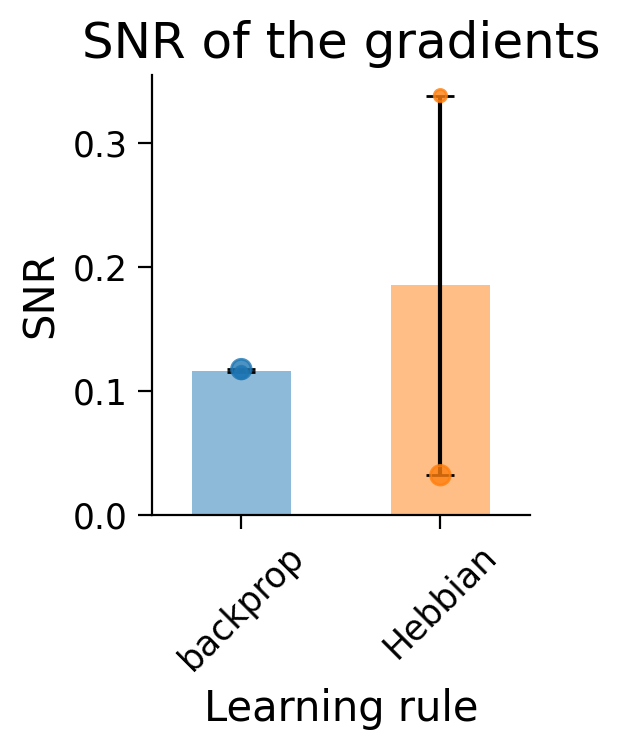

In [ ]:
SNR_dict = dict()
for model_type in ["backprop", "Hebbian"]:
  model_params = {
      "num_hidden": NUM_HIDDEN,
      "activation_type": ACTIVATION,
      "bias": BIAS,
  }

  if model_type == "Hebbian":
    model_fct = HebbianMultiLayerPerceptron
  else:
    model_fct = MultiLayerPerceptron

  model = model_fct(**model_params)

  model_SNR_dict = compute_gradient_SNR(model, valid_loader.dataset)

  SNR_dict[model_type] = [SNR for SNR in model_SNR_dict.values()]

plot_gradient_SNRs(SNR_dict);

The dots in the plots show the SNR **for each layer** (small dot: first layer; larger dot: second layer).  

Hebbian learning appears to have produced gradients with a very **high SNR** (and therefore lower variance) in the **first layer** (small dot). In constrast, the **second layer** (big dot) shows a **lower SNR** than error backpropagation.  

Notably, this is evaluated on the full 10-class task which Hebbian learning struggles to learn.

❓ **What does the Hebbian learning SNR look like for the 2-class version of the task?**  
❓ **What might this mean about how Hebbian learning learns?**  
❓ **Going further: How might this result relate to the Hebbian learning rule's performance on the classification task?**

#### 4.4.2 Estimating the gradient bias with respect to error backpropagation using the Cosine similarity.

The following functions measure and plot the Cosine similarity of the gradients to error backpropagation gradients:


In [ ]:
#@markdown `train_and_calculate_cosine_sim(MLP, train_loader, valid_loader, optimizer)`:
#@markdown Trains a model using a specific learning rule, while computing the cosine
#@markdown similarity of the gradients proposed the learning rule compared to those proposed
#@markdown by error backpropagation.
def train_and_calculate_cosine_sim(MLP, train_loader, valid_loader, optimizer,
                                   num_epochs=8):
  """
  Train model across epochs, calculating the cosine similarity between the
  gradients proposed by the learning rule it's trained with, compared to those
  proposed by error backpropagation.

  Arguments:
  - MLP (torch model): Model to train.
  - train_loader (torch dataloader): Dataloader to use to train the model.
  - valid_loader (torch dataloader): Dataloader to use to validate the model.
  - optimizer (torch optimizer): Optimizer to use to update the model.
  - num_epochs (int, optional): Number of epochs to train model.

  Returns:
  - cosine_sim (dict): Dictionary storing the cosine similarity between the
    model's learning rule and backprop across epochs, computed on the
    validation data.
  """

  criterion = torch.nn.NLLLoss()

  cosine_sim_dict = {key: list() for key in MLP.list_parameters()}

  for e in tqdm(range(num_epochs)):
    MLP.train()
    for X, y in train_loader:
      y_pred = MLP(X, y=y)
      loss = criterion(torch.log(y_pred), y)
      optimizer.zero_grad()
      if e != 0:
        loss.backward()
        optimizer.step()

    MLP.eval()
    lr_gradients_dict = {key: list() for key in cosine_sim_dict.keys()}
    backprop_gradients_dict = {key: list() for key in cosine_sim_dict.keys()}

    for X, y in valid_loader:
      # collect gradients computed with learning rule
      y_pred = MLP(X, y=y)
      loss = criterion(torch.log(y_pred), y)

      MLP.zero_grad()
      loss.backward()
      for key, value in MLP.gather_gradient_dict().items():
        lr_gradients_dict[key].append(value)
      MLP.zero_grad()

      # collect gradients computed with backprop
      y_pred = MLP.forward_backprop(X)
      loss = criterion(torch.log(y_pred), y)

      MLP.zero_grad()
      loss.backward()
      for key, value in MLP.gather_gradient_dict().items():
        backprop_gradients_dict[key].append(value)
      MLP.zero_grad()

    for key in cosine_sim_dict.keys():
      lr_grad = np.asarray(lr_gradients_dict[key])
      bp_grad = np.asarray(backprop_gradients_dict[key])
      if (lr_grad == 0).all():
        warnings.warn(
          f"Learning rule computed all 0 gradients for epoch {e}. "
          "Cosine similarity cannot be calculated."
          )
        epoch_cosine_sim = np.nan
      elif (bp_grad == 0).all():
        warnings.warn(
          f"Backprop. rule computed all 0 gradients for epoch {e}. "
          "Cosine similarity cannot be calculated."
          )
        epoch_cosine_sim = np.nan
      else:
        epoch_cosine_sim = calculate_cosine_similarity(lr_grad, bp_grad)

      cosine_sim_dict[key].append(epoch_cosine_sim)

  return cosine_sim_dict


def calculate_cosine_similarity(data1, data2):
    """
    Calculates the cosine similarity between two vectors.

    Arguments:
    - data1 (torch Tensor): first vector
    - data2 (torch Tensor): second vector
    """

    data1 = data1.reshape(-1)
    data2 = data2.reshape(-1)

    numerator = np.dot(data1, data2)
    denominator = (
        np.sqrt(np.dot(data1, data1)) * np.sqrt(np.dot(data2, data2))
      )

    cosine_sim = numerator / denominator

    return cosine_sim

#@markdown `plot_gradient_cosine_sims(cosine_sim_dict)`: Plots cosine similarity
#@markdown of the gradients proposed by a model across learning to those proposed
#@markdown by error backpropagation.
def plot_gradient_cosine_sims(cosine_sim_dict, ax=None):
  """
  Plot gradient cosine similarities to error backpropagation for various
  learning rules.

  Arguments:
  - cosine_sim_dict (dict): Gradient cosine similarities for each learning rule.
  - ax (plt subplot, optional): Axis on which to plot gradient cosine
    similarities. If None, a new axis will be created.

  Returns:
  - ax (plt subplot): Axis on which gradient cosine similarities were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(8, 4))

  max_num_epochs = 0
  for m, (model_type, cosine_sims) in enumerate(cosine_sim_dict.items()):
    cosine_sims = np.asarray(cosine_sims) # params x epochs
    num_epochs = cosine_sims.shape[1]
    x = np.arange(num_epochs)
    cosine_sim_means = np.nanmean(cosine_sims, axis=0)
    cosine_sim_sems = scipy.stats.sem(cosine_sims, axis=0, nan_policy="omit")

    ax.plot(x, cosine_sim_means, label=model_type, alpha=0.8)

    color = get_plotting_color(model_idx=m)
    ax.fill_between(
        x,
        cosine_sim_means - cosine_sim_sems,
        cosine_sim_means + cosine_sim_sems,
        alpha=0.3, lw=0, color=color
        )

    for i, param_cosine_sims in enumerate(cosine_sims):
      s = 20 + i * 30
      ax.scatter(x, param_cosine_sims, color=color, s=s, alpha=0.6)

    max_num_epochs = max(max_num_epochs, num_epochs)

  if max_num_epochs > 0:
    x = np.arange(max_num_epochs)
    xlabels = [f"{int(e)}" for e in x]
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)

  ymin = ax.get_ylim()[0]
  ymin = min(-0.1, ymin)
  ax.set_ylim(ymin, 1.1)

  ax.axhline(0, ls="dashed", color="k", zorder=-5, alpha=0.5)

  ax.set_xlabel("Epoch")
  ax.set_ylabel("Cosine similarity")
  ax.set_title("Cosine similarity to backprop gradients")
  ax.legend()

  return ax

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:43,  4.88s/it]

 20%|██        | 2/10 [00:10<00:40,  5.06s/it]

 30%|███       | 3/10 [00:15<00:35,  5.08s/it]

 40%|████      | 4/10 [00:20<00:30,  5.08s/it]

 50%|█████     | 5/10 [00:25<00:25,  5.10s/it]

 60%|██████    | 6/10 [00:30<00:20,  5.09s/it]

 70%|███████   | 7/10 [00:35<00:15,  5.09s/it]

 80%|████████  | 8/10 [00:40<00:10,  5.11s/it]

 90%|█████████ | 9/10 [00:45<00:05,  5.11s/it]

100%|██████████| 10/10 [00:50<00:00,  5.11s/it]

100%|██████████| 10/10 [00:50<00:00,  5.09s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:44,  4.92s/it]

 20%|██        | 2/10 [00:10<00:41,  5.21s/it]

 30%|███       | 3/10 [00:15<00:36,  5.27s/it]

 40%|████      | 4/10 [00:20<00:31,  5.29s/it]

 50%|█████     | 5/10 [00:26<00:26,  5.30s/it]

 60%|██████    | 6/10 [00:31<00:21,  5.29s/it]

 70%|███████   | 7/10 [00:36<00:15,  5.30s/it]

 80%|████████  | 8/10 [00:42<00:10,  5.29s/it]

 90%|█████████ | 9/10 [00:47<00:05,  5.30s/it]

100%|██████████| 10/10 [00:52<00:00,  5.28s/it]

100%|██████████| 10/10 [00:52<00:00,  5.28s/it]

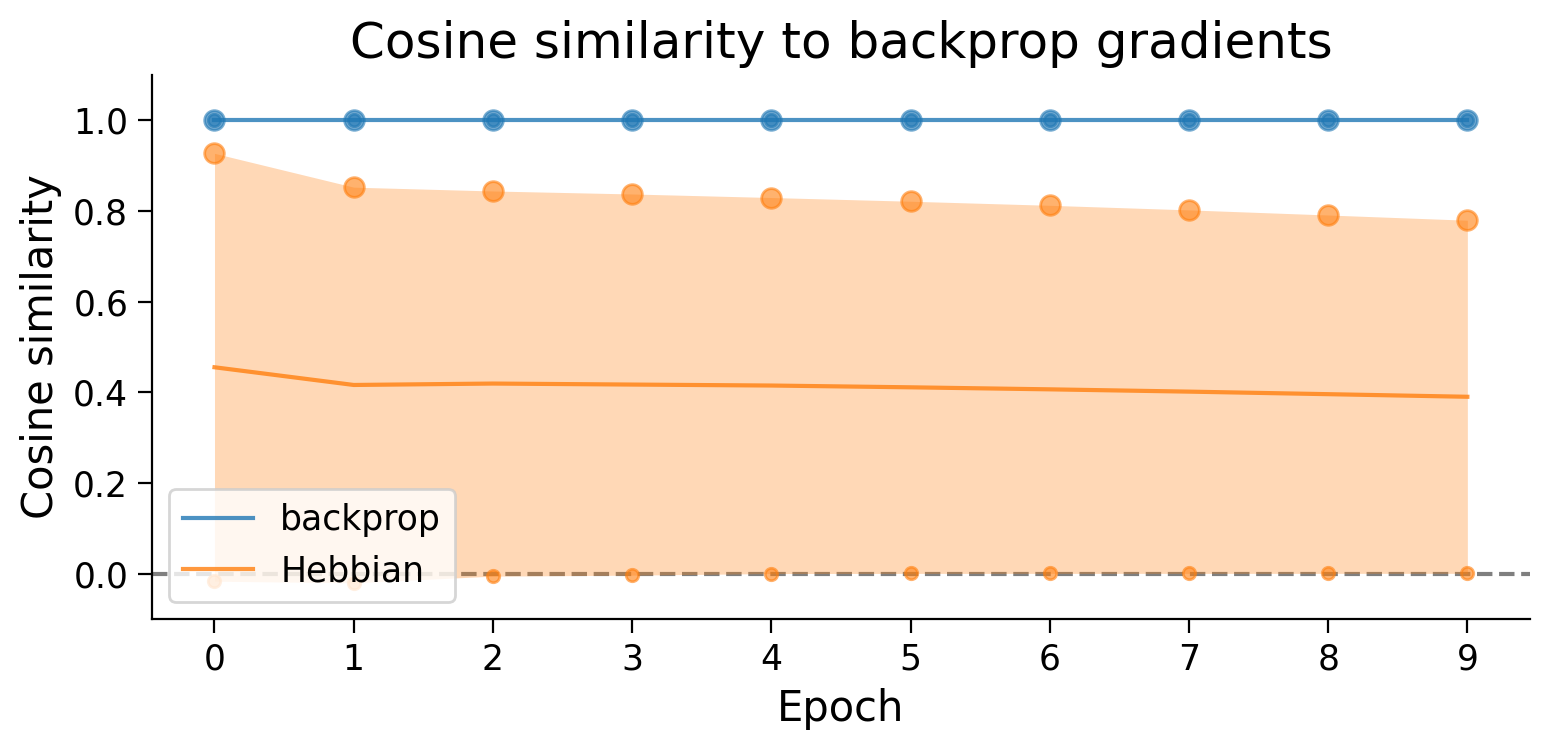

In [ ]:
NUM_EPOCHS = 10

cosine_sim_dict = dict()
for model_type in ["backprop", "Hebbian"]:
  model_params = {
      "num_hidden": NUM_HIDDEN,
      "activation_type": ACTIVATION,
      "bias": BIAS,
  }

  if model_type == "Hebbian":
    model_fct = HebbianMultiLayerPerceptron
    lr = HEBB_LR
  else:
    model_fct = MultiLayerPerceptron
    lr = LR

  model = model_fct(**model_params)

  optimizer = BasicOptimizer(model.parameters(), lr=lr)

  print(f"Collecting Cosine similarities for {model_type}-trained model...")
  model_cosine_sim_dict = train_and_calculate_cosine_sim(
      model, train_loader, valid_loader, optimizer, num_epochs=NUM_EPOCHS
      )

  cosine_sim_dict[model_type] = [
      cos_sim for cos_sim in model_cosine_sim_dict.values()
      ]

plot_gradient_cosine_sims(cosine_sim_dict);

As expected, gradient updates proposed by error backpropagation necessarily have **no bias** with respect to themselves (cosine similarity near 1.0). In contrast, although gradient updates proposed by Hebbian learning for the **second layer** (big dots) are **well aligned** with error backpropagation updates, the updates proposed for the **first layer** (small dots) are **highly biased** (cosine similarity near 0.0).

❓ **What might this result tell us about how Hebbian learning learns in this task?**  
❓ **What does the Hebbian learning cosine similarity to error backpropagation look like for the 2-class version of the task?**  
❓ **Going further: How might this result relate to the Hebbian learning rule's performance on the classification task?**

❓ **Taken together, what do the bias and variance properties of each layer tell us about how Hebbian learning learns in this task?**
❓ **Going futher: How learning rule-specific are the bias and variance properties of the gradients compared to other performance or learning metrics?**  
❓ **Going futher: How do the bias and variance of the gradients relate to the performance of a learning rule on a task?**  

## Section 5. Implementing additional learning rules

In this notebook, we implemented learning in a neural network using **Hebbian learning**, and examined how this learning rule performed under various scenarios. Hebbian learning is only one biologically plausible learning rule among many others. Importantly, many of these other rules are better suited to **supervised learning tasks** like image classification.

Examples of basic biologically plausible learning rules to explore include **node perturbation**, **weight_perturbation**, **feedback alignment**, and the **Kolen Pollack**.

Take a look at Neuromatch's NeuroAI tutorial for the Microlearning day for implementations of these algorithms using numpy. Then, see whether you can reimplement one or several of them using **custom `torch` autograd functions**, as demonstrated in this notebook.

Implementing certain learning rules may also require making some changes to how the **optimizer step** is performed. To do so, you can adapt the `BasicOptimizer()` or any other `torch` optimizer, as needed.

The following repositories could be very helpful resources, as they implement these learning rules using custom `torch` autograd functions:
- **Feedback alignment:** https://github.com/L0SG/feedback-alignment-pytorch/blob/master/lib/fa_linear.py
- **Kolen-Pollack:** https://github.com/limberc/DL-without-Weight-Transport-PyTorch/blob/master/linear.py. Also take a look at `main.py` to see how they adapt the SGD optimizer to produce the correct updates for Kolen Pollack.

## Section 6. Tips & suggestions

Here are a few tips that may be helpful as you delve into questions from the project template.

- **Testing whether the metrics are specific to a learning rule:** There are a few ways to assess whether certain performance and learning metrics are specific to a learning rule. Examples include:
  - **Visualization:** You could plot the metrics or a lower-dimensional version of the metrics to visualize whether the metrics for each learning rule form separate clusters or whether they all mix together.
  - **Classification:** You could test whether a linear classifier can be trained to correctly predict the learning rule from the metrics.

- **Assessing how your models respond to more challenging learning scenarios**: There are several challenging learning scenarios you can implement. Examples include:  
  - **Online learning:** Training with a batch size of one.
  - **Non-stationary data:** Changing the distribution of the data across learning. Here, the `restrict_classes(dataset)` function may be useful. For example, you could initially train a model on a dataset with no examples from the `6` class, and then introduce examples from the `6` class partway through training to see how this affects learning.

## Additional References
Original papers introducing these biologically plausible learning rules:
- Node perturbation (Andes et al., 1990, IJCNN)
- Weight perturbation ([Mazzoni et al., 1991, PNAS](https://www.pnas.org/doi/abs/10.1073/pnas.88.10.4433))
- Feedback alignment ([Lillicrap et al., 2016, Nature Communications](https://www.nature.com/articles/ncomms13276))
- Kolen-Pollack algorithm ([Kolen & Pollack, 1994, ICNN](https://ieeexplore.ieee.org/document/374486); [Akrout et al., 2019, NeurIPS](https://arxiv.org/abs/1904.05391))

### ⭐ We hope you enjoy working on your project and, through the process, make some interesting discoveries about the challenges and potentials of biologically plausible learning! ⭐